Necessary imports

In [3]:
# top level imports
from pathlib import Path
import os, sys


import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import _assert_uint16_labels
from infer_subc.utils.stats_helpers import *
from infer_subc.organelles import *
from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH )   

import time
from napari.utils.notebook_display import nbscreenshot
%load_ext autoreload
%autoreload 2


# PROJECTION STATS NOTEBOOK 📊



══════════════════════════════════════════════════════════════════════════════════════════════════

# Background

Measurements regarding the shape and size of the cell components are essential to the process of forming conclusions. However, these measurements alone do not describe the cell sufficiently. The distribution (whether it be of components, volume, or intensity) within the cell is just as importtant in terms of gaining useful understanding. This is done within the function get_radial_stats, which in itself contains numerous robust functions. Consequently, the sheer amount of code within these functions can be overwhelming to read at once. 

The get_radial stats function as well as the intermediate functions will be thoroughly analyzed and explanations will be provided for portions of the code that is not directly intuitive. Modifications will be made as well with the goal of improving the accuracy and readability of the data output. Although most of the updates are minuscule, there is one previously mentioned in notebook 11_1_scale_and_spacing. This change is an argument called `keep_nuc_bins` which existed previously but was never enabled for use. This argument provides the user with the option to create n bins with the nucleus projection being the initial bin (TRUE) or to create n bins that protrude from the nucleus (FALSE). This gives the user more control as they can decide the parameters of how their data is created.

# INPUTS FOR THE RADIAL STATS FUNCTIONS

In [4]:
# this will be the example image for testing the pipeline below
test_img_n = 1

test_org = 5

number_of_bins = 5

#The bin that will be used in visualization when the bins are spilt up into 8 sections
bin = 4

# This is because the napari output names made it difficult for the functions to the .tiff files
phrase = "20230606_testnrm"

# CHOOSING THE CELL

In [5]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path("C:/Users/redre/Documents/CohenLab/MSI-3D-analysis/20230606_test_files_practice_analysis")

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "test_files"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "20230606_out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [6]:
print(test_img_name)

C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\test_files\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi


In [7]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

source_file = meta_dict['file_name']

c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [8]:
viewer = napari.Viewer(title = "Test Cell", ndisplay=3)

This is the ER Channel of the image data

In [9]:
viewer.layers.clear()
viewer.add_image(img_data[ER_CH],
                scale=scale,
                rotate = (5,5,0))

c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(


<Image layer 'Image' at 0x213e2ca29b0>

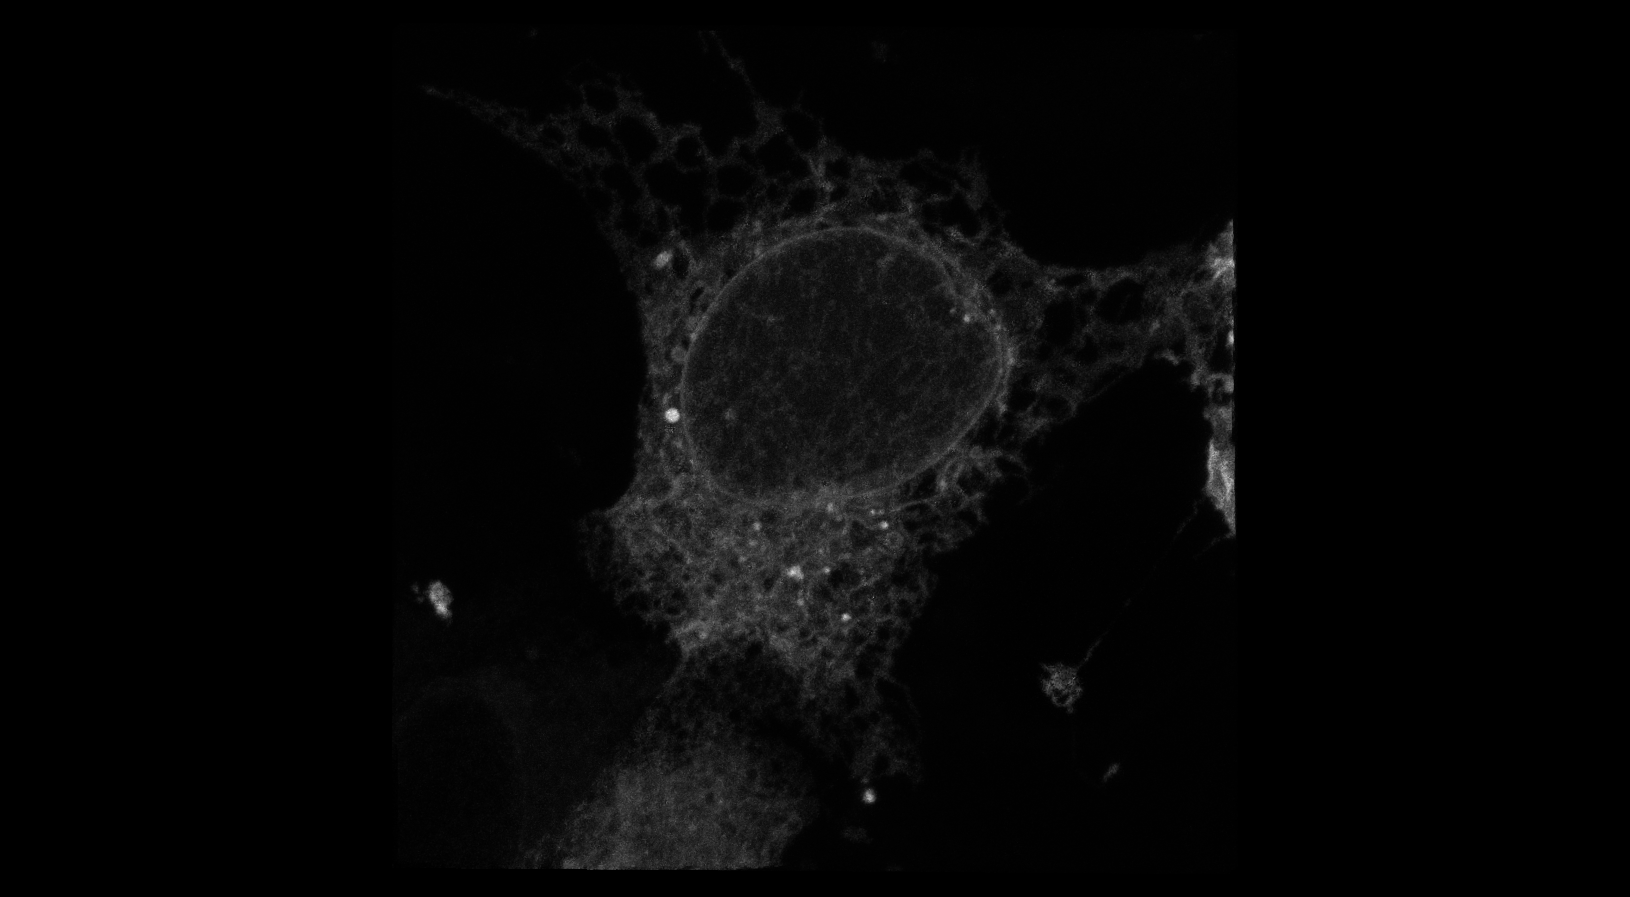

In [10]:
nbscreenshot(viewer, canvas_only=True)

Retrieving the objects

In [11]:
nuclei_obj =  import_inferred_organelle(f"{phrase}_nuc",meta_dict,out_data_path)
cellmask_obj = import_inferred_organelle(f"{phrase}_cell",meta_dict,out_data_path)
cyto_mask = import_inferred_organelle(f"{phrase}_cyto",meta_dict,out_data_path)

loaded  inferred 3D `20230606_testnrm_nuc`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_cell`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_cyto`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 


Getting the masks and the intensities

In [12]:
organelle_names = ["nuc","lyso", "mito","golgi","perox","ER","LD"]

organelle_masks = []
for name in organelle_names:
    organelle_masks.append(import_inferred_organelle((f'{phrase}_{name}'),meta_dict,out_data_path))
organelle_channels = [NUC_CH,
                      LYSO_CH,
                      MITO_CH,
                      GOLGI_CH,
                      PEROX_CH,
                      ER_CH,
                      LD_CH]

original_intensities = []
for chan in organelle_channels:
    original_intensities.append(img_data[chan])


loaded  inferred 3D `20230606_testnrm_nuc`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_lyso`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_mito`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_golgi`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_perox`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_ER`  from C:\Users\redre\Documents\CohenLab\MSI-3D-analysis\20230606_test_files_practice_analysis\20230606_out 
loaded  inferred 3D `20230606_testnrm_LD`  from C:\Users\redre\Documents\CohenLab\MSI-3D-

INPUTS FOR THE RADIAL STATS FUNCTION

In [13]:
# args 
cellmask_obj
nuclei_obj
# The orgnalle masked was original the cytoplasm obj, but this was changed to be the cellmask object. Without this modification, keep_nuc_bins is
# essentially pointless as the nucleus would be excluded from the projections.
organelle_mask = cellmask_obj
organelle_name = organelle_names[test_org]
org_obj = organelle_masks[test_org]
org_img = original_intensities[test_org]

n_rad_bins = number_of_bins
n_zernike = 9

target = organelle_name


## Updates on `get_radial_distribution`
 - Scale argument added for anisotrophic data
 - normalized distance and good mask were added as outputs

In [43]:
def nrm_get_radial_distribution(
        cellmask_proj: np.ndarray,
        org_proj: np.ndarray,
        img_proj: np.ndarray,
        org_name: str,
        nucleus_proj: np.ndarray,
        n_bins: int = 5,
        from_edges: bool = True,
        keep_nuc_bins = True,
        scale: Union[tuple,None] = None 
    ):
    """Perform the radial measurements on the image set

    Parameters
    ------------
    cellmask_proj: np.ndarray,
    org_proj: np.ndarray,
    img_proj: np.ndarray,
    org_name: str,
    nucleus_proj: np.ndarray,
    n_bins: int = 5,
    from_edges: bool = True,
    keep_nuc_bins = True,
    scale: Union[tuple,None] = None

    masked

    # params
    #   n_bins .e.g. 6
    #   normalizer - cellmask_voxels, organelle_voxels, cellmask_and_organelle_voxels
    #   from_edges = True


    Returns
    -------------
    returns one statistics table + bin_indexes image array
    """

    # other params
    bin_count = n_bins if n_bins is not None else 5
    nobjects = 1

    # This was not assigned to anything, so I have commented it out. Also there is code to scale the bins now
    # scale_bins = True

    # This has also because this is now an argument
    # keep_nuc_bins = True
    
    center_on_nuc = False # choosing the edge of the nuclei or the center as the center to propogate from

    center_objects = nucleus_proj>0 

    # labels = label(cellmask_proj>0) #extent as 0,1 rather than bool

    # labels = np.zeros_like(cellmask_proj)
    # labels[labels>0]=1   

    labels = (cellmask_proj>0).astype(np.uint16)

    ### an if statement as part as the option to omit the nucleus 
    if not keep_nuc_bins:
        labels[center_objects] = 0

    ################   ################
    ## define masks for computing distances
    ################   ################
    normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, keep_nuc_bins)
    
    if normalized_distance is None:
        print('WTF!!  normailzed_distance returned wrong')

    ################   ################
    ## get histograms
    ################   ################
    ngood_pixels = np.sum(good_mask)
    good_labels = labels[good_mask]

    # protect against None normaized_distances
    if keep_nuc_bins:
        # For the exterior bins
        bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)
        bin_indexes[~good_mask] = 0
        # For the nucleus bin
        bin_indexes[center_objects] = 0
    else:
        bin_indexes = (normalized_distance * (bin_count)).astype(int)
    
    bin_indexes[bin_indexes > bin_count] = bin_count # shouldn't do anything

    #                 (    i          ,         j              )
    labels_and_bins = (good_labels - 1, bin_indexes[good_mask])

    #                coo_matrix( (             data,             (i, j)    ), shape=                      )
    histogram_cmsk = coo_matrix( (cellmask_proj[good_mask], labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_org = coo_matrix(  (org_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_img = coo_matrix(  (img_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()

    if keep_nuc_bins:
        # For the exterior bins
        bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)
        bin_indexes[~good_mask] = 0
        # For the nucleus bin
        bin_indexes[center_objects] = 0
    else:
        bin_indexes = (normalized_distance * (bin_count)).astype(int)

    sum_by_object_cmsk = np.sum(histogram_cmsk, 1) # flattened cellmask voxel count
    sum_by_object_org = np.sum(histogram_org, 1)  # organelle voxel count
    sum_by_object_img = np.sum(histogram_img, 1)  # image intensity projection

    # DEPRICATE: since we are NOT computing object_i by object_i (individual organelle labels)
    # sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count + 1))[0]
    # fraction_at_distance = histogram / sum_by_object_per_bin

    # number of bins.
    number_at_distance = coo_matrix(( np.ones(ngood_pixels), labels_and_bins), (nobjects, bin_count)).toarray()

    # sicne we aren't breaking objects apart this is just ngood_pixels

    sum_by_object = np.sum(number_at_distance, 1)

    sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count))[0]
    fraction_at_bin = number_at_distance / sum_by_object_per_bin # sums to 1.0

    # object_mask = number_at_distance > 0
    # DEPRICATE:# not doing over multiple objects so don't need object mask.. or fractionals
    # mean_pixel_fraction = fraction_at_distance / ( fraction_at_bin + np.finfo(float).eps )
    # masked_fraction_at_distance = np.ma.masked_array( fraction_at_distance, ~object_mask )
    # masked_mean_pixel_fraction = np.ma.masked_array(mean_pixel_fraction, ~object_mask)

    ################   ################
    ## collect Anisotropy calculation.  + summarize
    ################   ################
    # Split each cell into eight wedges, then compute coefficient of variation of the wedges' mean intensities
    # in each ring. Compute each pixel's delta from the center object's centroid
    i, j = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]
    imask = i[good_mask] > i_center[good_mask]
    jmask = j[good_mask] > j_center[good_mask]
    absmask = abs(i[good_mask] - i_center[good_mask]) > abs(
        j[good_mask] - j_center[good_mask]
    )
    radial_index = (
        imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4
    )

    # return radial_index, labels, good_mask, bin_indexes
    statistics = []
    stat_names =[]
    cv_cmsk = []
    cv_obj = []
    cv_img = []
    # collect the numbers from each "bin"
    for bin in range(bin_count):
        bin_mask = good_mask & (bin_indexes == bin)
        bin_pixels = np.sum(bin_mask)

        bin_labels = labels[bin_mask]

        bin_radial_index = radial_index[bin_indexes[good_mask] == bin]
        labels_and_radii = (bin_labels - 1, bin_radial_index)
        pixel_count = coo_matrix( (np.ones(bin_pixels), labels_and_radii), (nobjects, 8) ).toarray()

        radial_counts_cmsk = coo_matrix( (cellmask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_counts = coo_matrix( (org_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_values = coo_matrix( (img_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()

        # we might need the masked arrays for some organelles... but I think not. keeping for now
        mask = pixel_count == 0

        radial_means_cmsk = np.ma.masked_array(radial_counts_cmsk / pixel_count, mask)
        radial_cv_cmsk = np.std(radial_means_cmsk, 1) / np.mean(radial_means_cmsk, 1)
        radial_cv_cmsk[np.sum(~mask, 1) == 0] = 0
        radial_cv_cmsk.mask = np.sum(~mask, 1) == 0


        radial_means_obj = np.ma.masked_array(radial_counts / pixel_count, mask)
        radial_cv_obj = np.std(radial_means_obj, 1) / np.mean(radial_means_obj, 1)
        radial_cv_obj[np.sum(~mask, 1) == 0] = 0
        radial_cv_obj.mask = np.sum(~mask, 1) == 0

        radial_means_img = np.ma.masked_array(radial_values / pixel_count, mask)
        radial_cv_img = np.std(radial_means_img, 1) / np.mean(radial_means_img, 1)
        radial_cv_img[np.sum(~mask, 1) == 0] = 0
        radial_cv_img.mask = np.sum(~mask, 1) == 0

        if keep_nuc_bins:
            bin_name = str(f'bin_{bin})') if bin > 0 else "nuc_bin"
        else: 
            bin_name = str(f'bin_{bin})')
        # # there's gotta be a better way to collect this stuff together... pandas?
        # statistics += [
        #     (   bin_name,
        #         # np.mean(number_at_distance[:, bin]), 
        #         # np.mean(histogram_cmsk[:, bin]), 
        #         # np.mean(histogram_org[:, bin]), 
        #         # np.mean(histogram_img[:, bin]), 
        #         np.mean(radial_cv_cmsk) ,
        #         np.mean(radial_cv_obj) ,
        #         np.mean(radial_cv_img) )
        # ]
        stat_names.append(bin_name)
        cv_cmsk.append(float(np.mean(radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
        cv_obj.append(float(np.mean(radial_cv_obj)))
        cv_img.append(float(np.mean(radial_cv_img))) # fixed the error

    # TODO: fix this grooooos hack
    # col_names=['organelle','mask','bin','n_bins','n_pix','cm_vox_cnt','org_vox_cnt','org_intensity','cm_radial_cv','org_radial_cv','img_radial_cv']
    # stats_dict={'organelle': org_name,
    #             'mask': 'cell',
    #             'radial_n_bins': bin_count,
    #             'radial_bins': [[s[0] for s in statistics]],
    #             'radial_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
    #             'radial_org_vox_cnt': [histogram_org.squeeze().tolist()],
    #             'radial_org_intensity': [histogram_img.squeeze().tolist()],
    #             'radial_n_pix': [number_at_distance.squeeze().tolist()],
    #             'radial_cm_cv':[[s[1] for s in statistics]],
    #             'radial_org_cv':[[s[2] for s in statistics]],
    #             'radial_img_cv':[[s[3] for s in statistics]],
    #             }
    
    stats_dict={'organelle': org_name,
                'mask': 'cell',
                'radial_n_bins': bin_count,
                'radial_bins': [stat_names],
                'radial_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
                'radial_org_vox_cnt': [histogram_org.squeeze().tolist()],
                'radial_org_intensity': [histogram_img.squeeze().tolist()],
                'radial_n_pix': [number_at_distance.squeeze().tolist()],
                'radial_cm_cv':[cv_cmsk],
                'radial_org_cv':[cv_obj],
                'radial_img_cv':[cv_img],
                }
    # added to implement scale
    if scale is not None:
        stats_dict["Scaled"] = "Yes",
        for i,dim in enumerate(scale):
            stats_dict[f"scale_dim{i}"] = str(dim),
        stats_dict['radial_cm_vol'] = [(histogram_cmsk * np.prod(scale)).squeeze().tolist()],
        stats_dict['radial_org_vol'] = [(histogram_org * np.prod(scale)).squeeze().tolist()],
        stats_dict['radial_n_area'] =  [(number_at_distance * np.prod(scale[1:])).squeeze().tolist()]
    else:
        stats_dict["Scaled"] = "No"



    # stats_tab = pd.DataFrame(statistics,columns=col_names)
    stats_tab = pd.DataFrame(stats_dict)  
    return stats_tab, bin_indexes, normalized_distance, good_mask

In [15]:
def nrm_get_zernike_stats(        
        cellmask_proj: np.ndarray,
        org_proj:np.ndarray,
        img_proj: np.ndarray,
        organelle_name: str,
        nucleus_proj: Union[np.ndarray, None] = None,
        zernike_degree: int = 9):

    """
    
    """

    labels = label(cellmask_proj>0) #extent as 0,1 rather than bool
    zernike_indexes = centrosome.zernike.get_zernike_indexes( zernike_degree + 1)


    z = zernike_polynomial(labels, zernike_indexes)

    z_cm = zernicke_stat(cellmask_proj, z)
    z_org = zernicke_stat(org_proj, z)
    z_nuc = zernicke_stat(nucleus_proj, z)
    z_img = zernicke_stat(img_proj, z)


    # nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
    stats_tab = pd.DataFrame({'organelle':organelle_name,
                                'mask':'cell',
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_cm_mag':[z_cm[0].tolist()],
                                'zernike_cm_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_nuc_mag':[z_nuc[0].tolist()],
                                'zernike_nuc_phs':[z_nuc[1].tolist()],
                                'zernike_img_mag':[z_img[0].tolist()],
                                'zernike_img_phs':[z_img[1].tolist()]} # 'zernike_img_mag':[z_img[1].tolist()]} error fixed
                                )

    return stats_tab

## Updates on `get_radial_stats`
 - Scale argument added for anisotrophic data
 - normalized distance and good mask were added to the outputs of `get_radial_distribution`

In [18]:
def nrm_get_radial_stats(        
        cellmask_obj: np.ndarray,
        organelle_mask: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_img: np.ndarray,
        organelle_name: str,
        nuclei_obj: np.ndarray,
        n_rad_bins: Union[int,None] = None,
        n_zernike: Union[int,None] = None,
        keep_nuc_bins: bool = True,
        scale: Union[tuple,None] = None 
        ):

    """
    Params


    Returns
    -----------
    rstats table of radial distributions
    zstats table of zernike magnitudes and phases
    rad_bins image of the rstats bins over the cellmask_obj 

    """


    # flattened
    cellmask_proj = create_masked_Z_projection(cellmask_obj)
    org_proj = create_masked_Z_projection(organelle_obj,organelle_mask.astype(bool))
    img_proj = create_masked_Z_projection(organelle_img,organelle_mask.astype(bool), to_bool=False)

    nucleus_proj = create_masked_Z_projection(nuclei_obj,cellmask_obj.astype(bool))

    # normalized distance and good mask were added to the outputs for visualization purposes

    radial_stats, radial_bin_mask, normalized_distance, good_mask = nrm_get_radial_distribution(cellmask_proj=cellmask_proj, 
                                                            org_proj=org_proj, 
                                                            img_proj=img_proj, 
                                                            org_name=organelle_name, 
                                                            nucleus_proj=nucleus_proj, 
                                                            n_bins=n_rad_bins,
                                                            keep_nuc_bins=keep_nuc_bins,
                                                            scale=scale)
    
    zernike_stats = nrm_get_zernike_stats(
                                      cellmask_proj=cellmask_proj, 
                                      org_proj=org_proj, 
                                      img_proj=img_proj, 
                                      organelle_name=organelle_name, 
                                      nucleus_proj=nucleus_proj, 
                                      zernike_degree = n_zernike)

    return radial_stats,zernike_stats,radial_bin_mask

BROKEN DOWN GET RADIAL DISTRIBUTION FUNCTION

### INPUTS

In [22]:
### Establishes the total area of the cellmask projection (imagine you are looking down on the cellmask, and you smush it down on the xy plane.)
cellmask_proj = create_masked_Z_projection(cellmask_obj)

# Changed the mask to cellmask
# Establishes the lysosome object projection as the organelle projection
org_proj = create_masked_Z_projection(org_obj,cellmask_obj)

# Changed the mask to cellmask
# Establishes the lysosome image projection for the intensities, changed code so it would not be bool
img_proj = create_masked_Z_projection(org_img,cellmask_obj,to_bool=False)

# The name of the organelle being measured in the projection stats
org_name = organelle_names[test_org]

# The nucleus projections
nucleus_proj = create_masked_Z_projection(nuclei_obj,cellmask_obj)

# The number of bins
n_bins = 5

# If the bins propogate from the edges if the nucleus rather than the center of the nucleus
from_edges = True

# If added, the parameters by which the data will be scaled by in order to output real world units
scale = scale

In [24]:
viewer = napari.Viewer(title = "Radial Distribution")

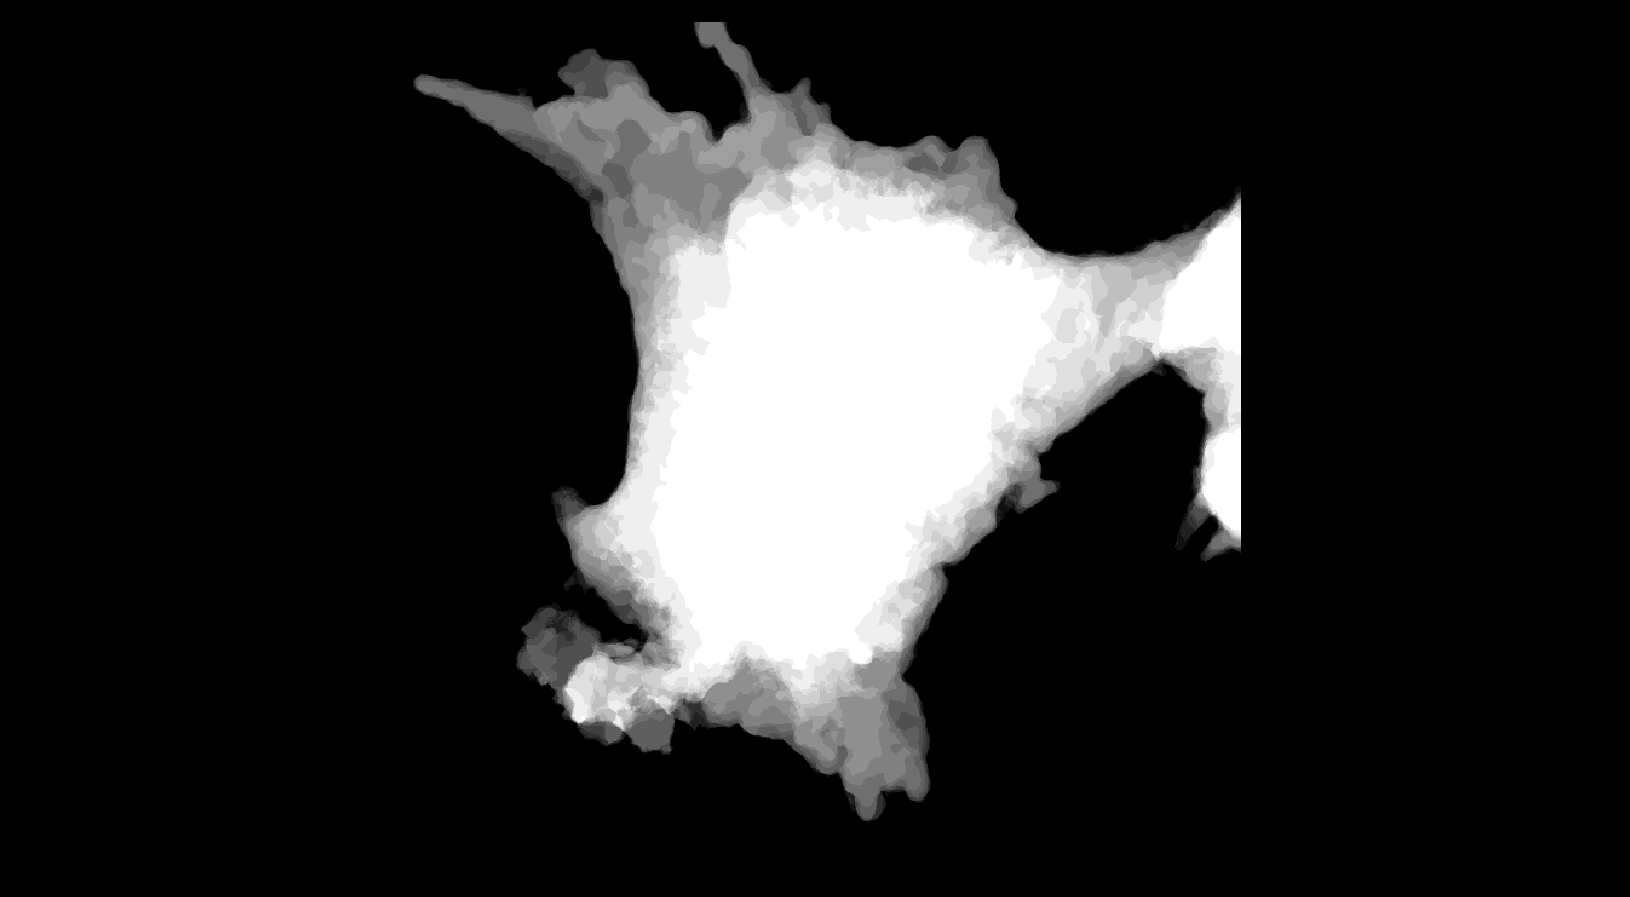

In [25]:
viewer.add_image(cellmask_proj)
nbscreenshot(viewer, canvas_only=True)

How bright a pixel is representitive of the depth of the cellmask in that (x,y)

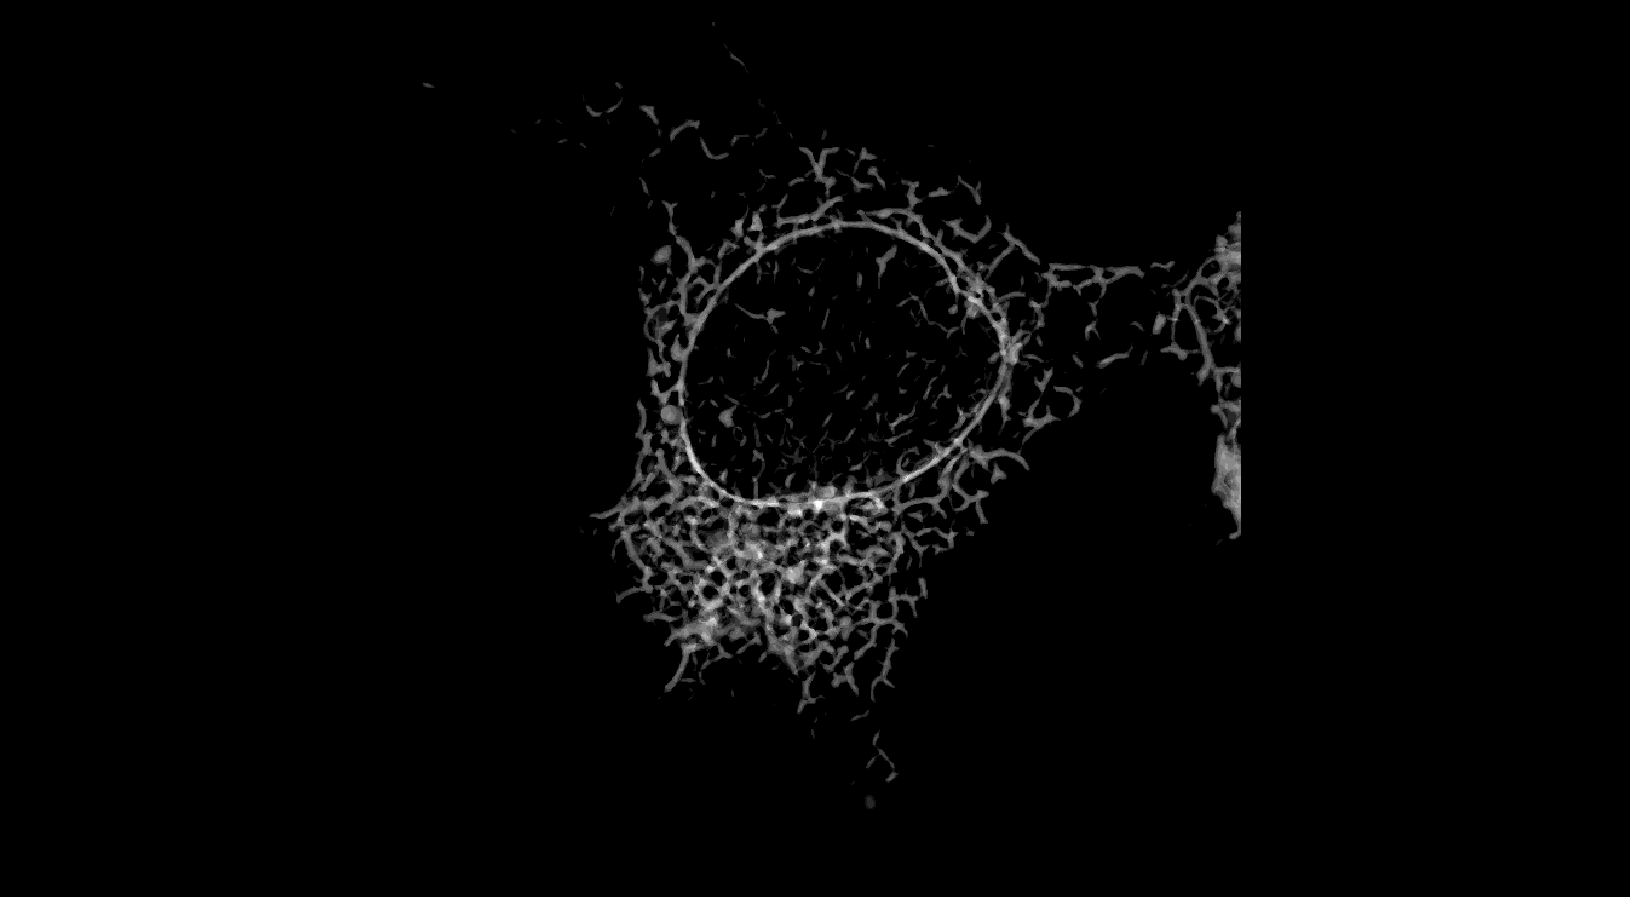

In [26]:
viewer.add_image(org_proj)
nbscreenshot(viewer, canvas_only=True)

How bright a pixel is represents how many times the lysosome object appeared in the z planes (depth), for that (x,y)

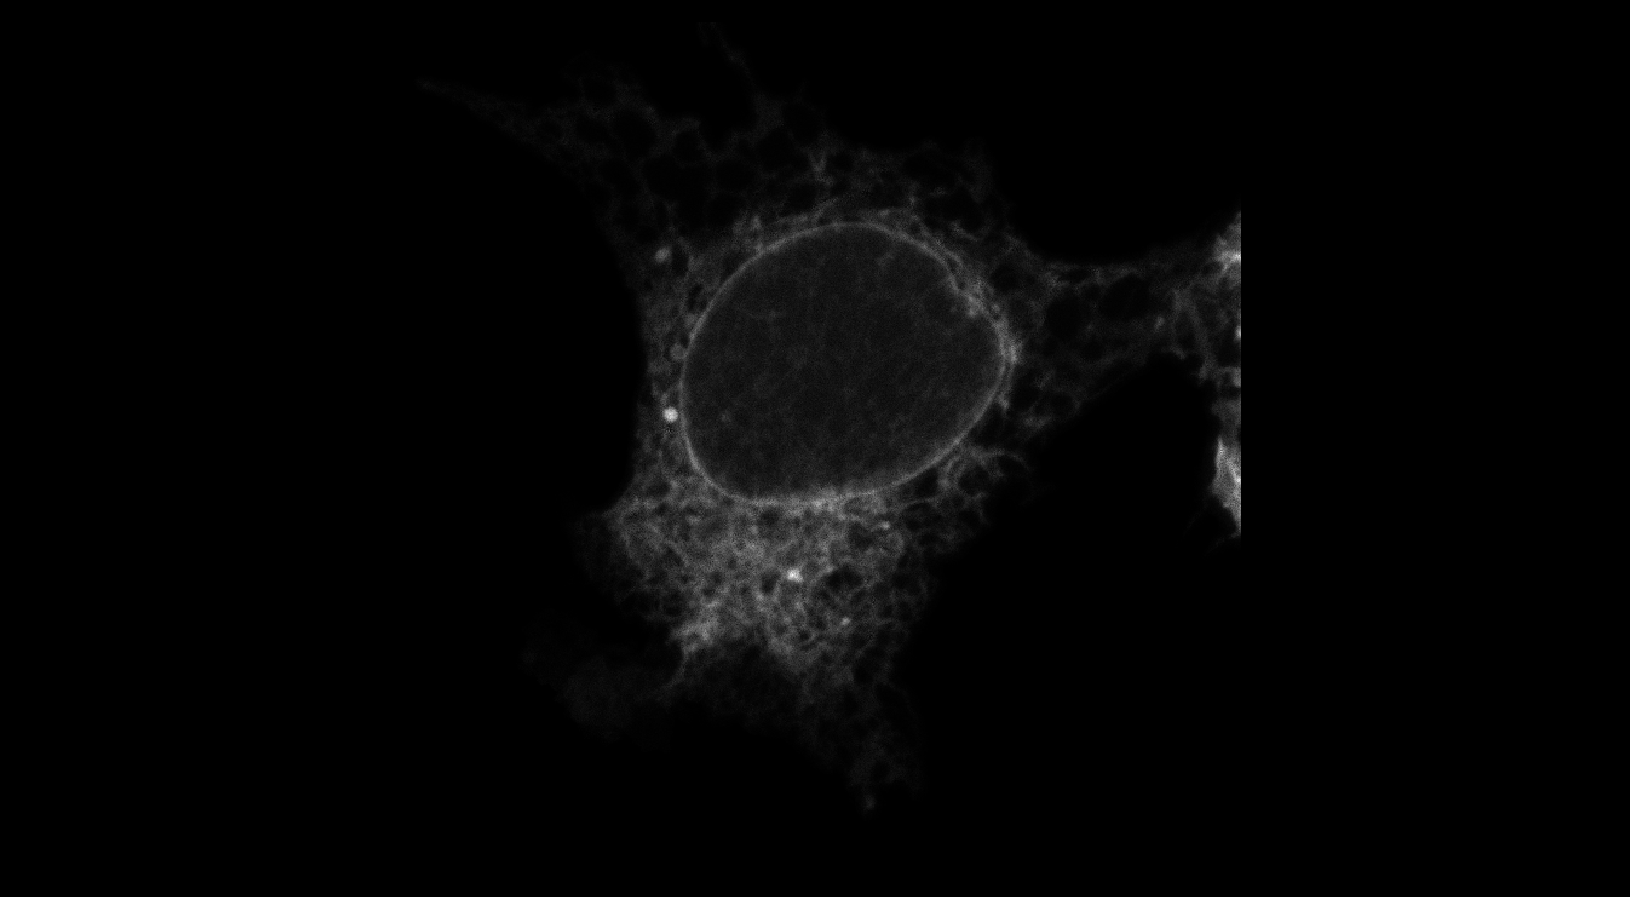

In [27]:
if np.max(img_proj) > 2**16:
     m = np.max(img_proj)
     for_nap = (img_proj / m) * 2**16
     viewer.add_image(for_nap.astype(int))
else:
     viewer.add_image(img_proj)
nbscreenshot(viewer, canvas_only=True)

The intensities summed on the Z axis, (remember that this was masked earlier, so there are no intensities from other cells).

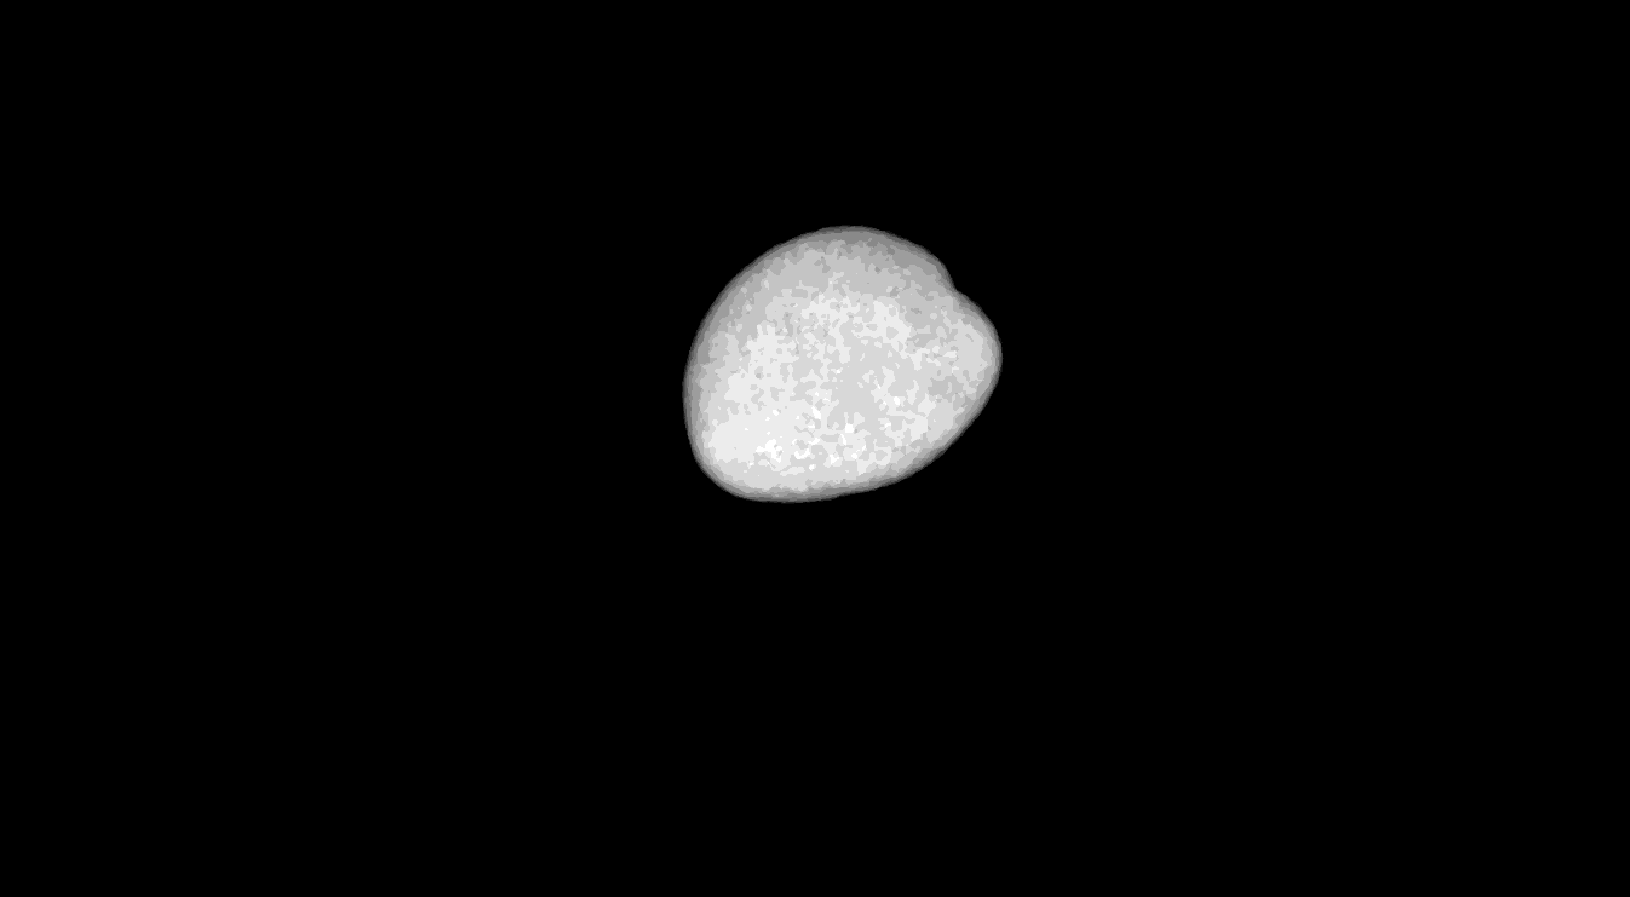

In [29]:
viewer.add_image(nucleus_proj)
nbscreenshot(viewer, canvas_only=True)

How bright a pixel is representative of the depth of the nucleus in that (x,y)

In [30]:
# Sets the amount of bins to a default of 5 if there is an issue with the value
bin_count = n_bins if n_bins is not None else 5
# The number of rows the output lists will have (the output will be shaped (1 x number of bins))
nobjects = 1

# Whether to count things within the nuclei mask
keep_nuc_bins = True

# Whether to propogate from the edge of the cell or center of the nucleus
center_on_nuc = False

# Establishes center_objects as a boolean image of the nucleus_proj, thus making a mask out of the nucleus projection
center_objects = nucleus_proj>0

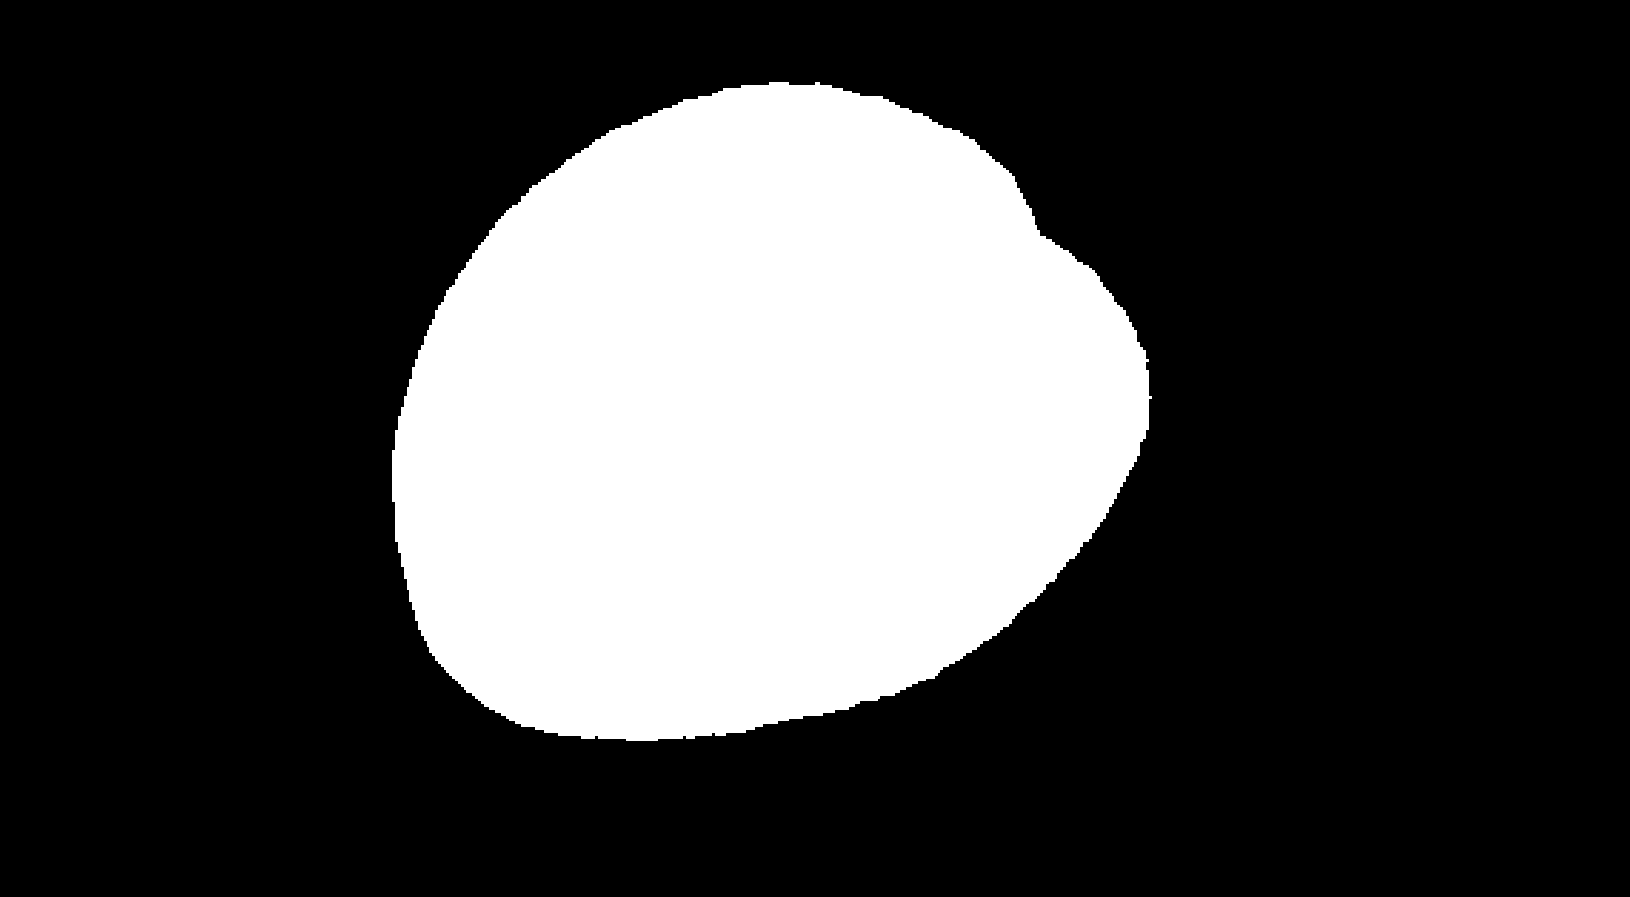

In [31]:
viewer.add_image(center_objects)
nbscreenshot(viewer, canvas_only=True)

Notice how the brightness no longer varies

In [35]:
# Confirming that it is a boolean array
np.unique(center_objects), center_objects.dtype

(array([False,  True]), dtype('bool'))

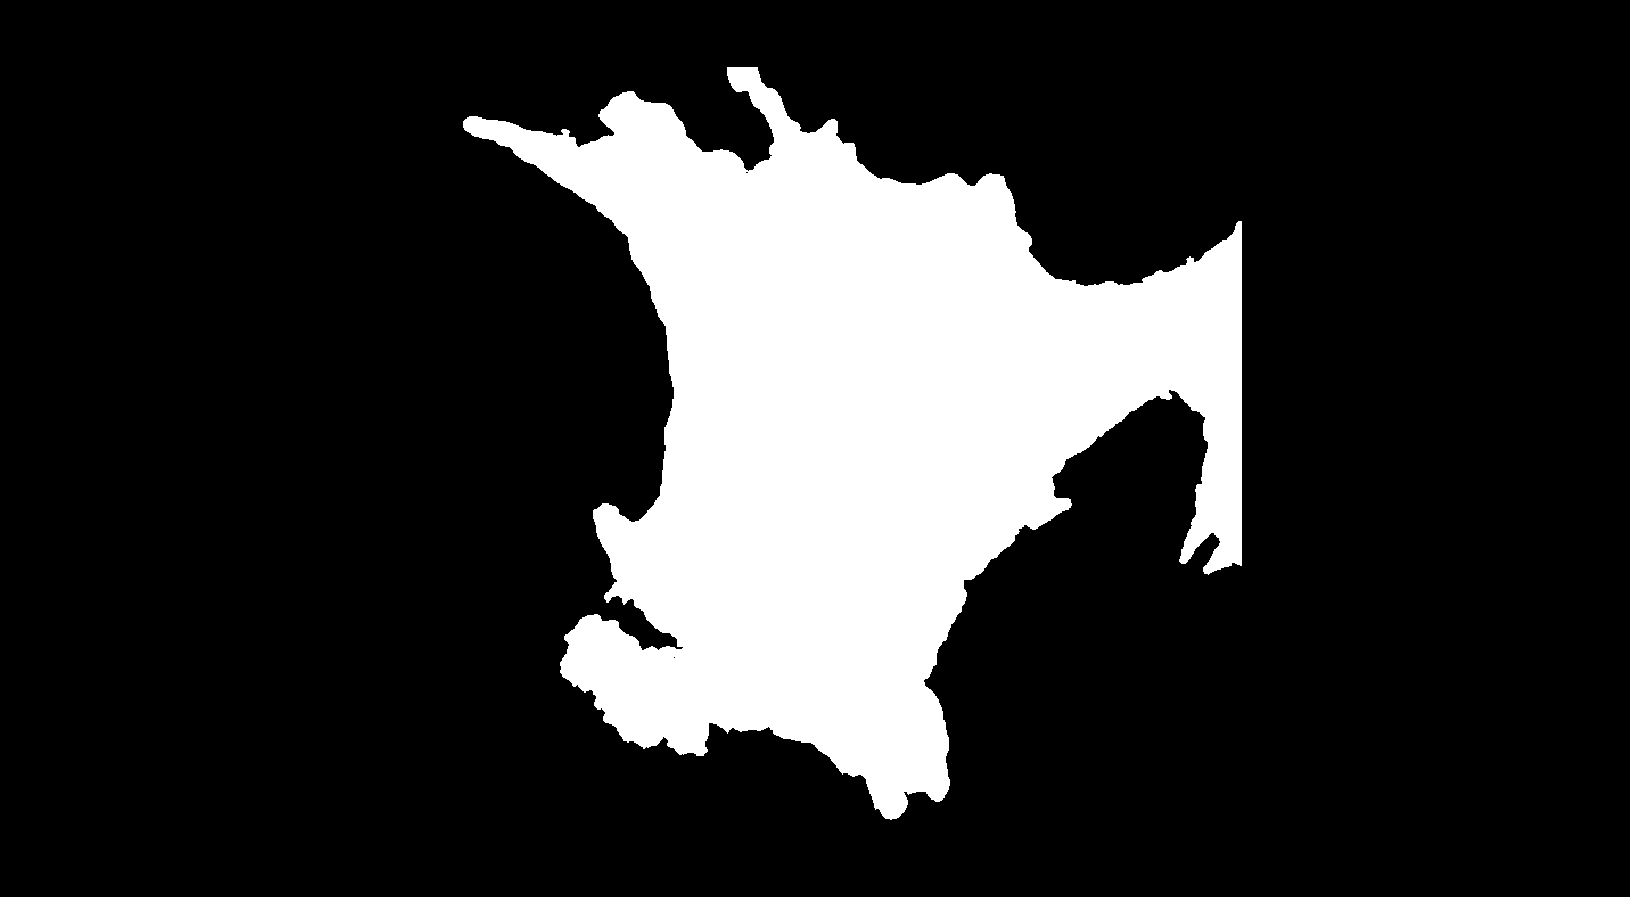

In [40]:
# Establishes labels as a boolean (but using 1's and 0's) array version of the cellmask projection
labels = (cellmask_proj>0).astype(np.uint16)

# if the keep nuc bins option were true, this next line would remove the nucleus projection from the cellmask.
if not keep_nuc_bins:
        labels[center_objects] = 0

viewer.add_image(labels)
nbscreenshot(viewer, canvas_only=True)

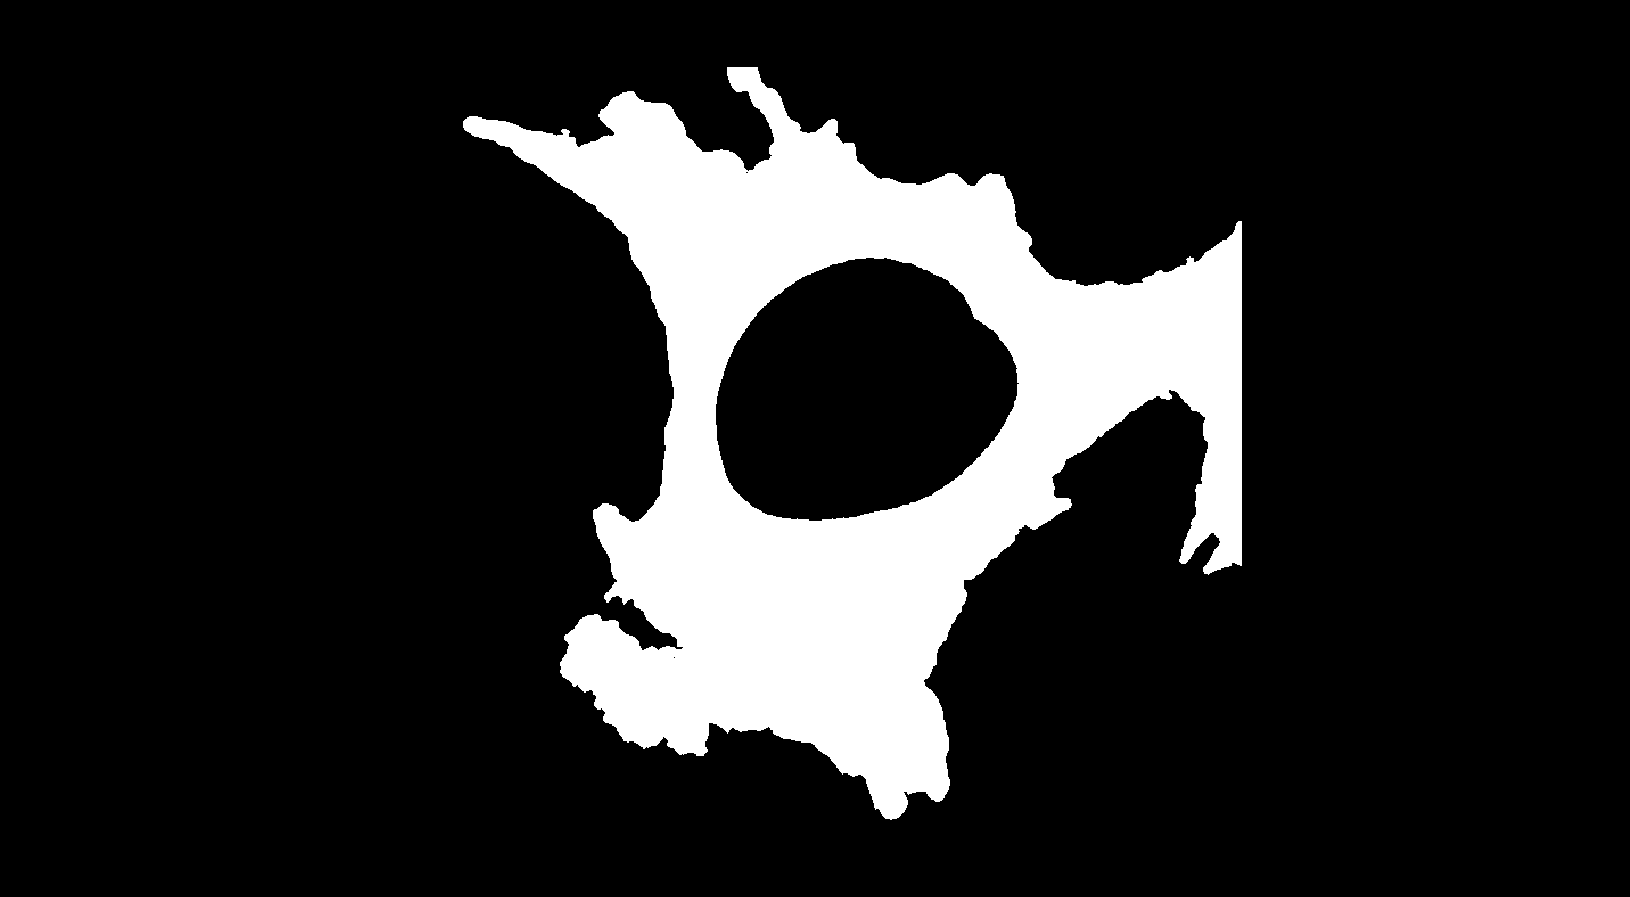

In [42]:
# This is what labels would look like if the keep_nuc_bins was false

labels2 = np.copy(labels)

labels2[center_objects] = 0
viewer.add_image(labels2)
nbscreenshot(viewer, canvas_only=True)

In [84]:
# The get_normalized_distance_and_mask function has four outputs that will be explained

normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, keep_nuc_bins)

In [87]:
# This is what the outputs would be if keep_nuc_bins was false. The good mask will be kept for the sake of camparison as it is
# The only one affected
_normalized_distance2, good_mask2, _i_center2, _j_center2 = get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, False)

### Normalized Distance

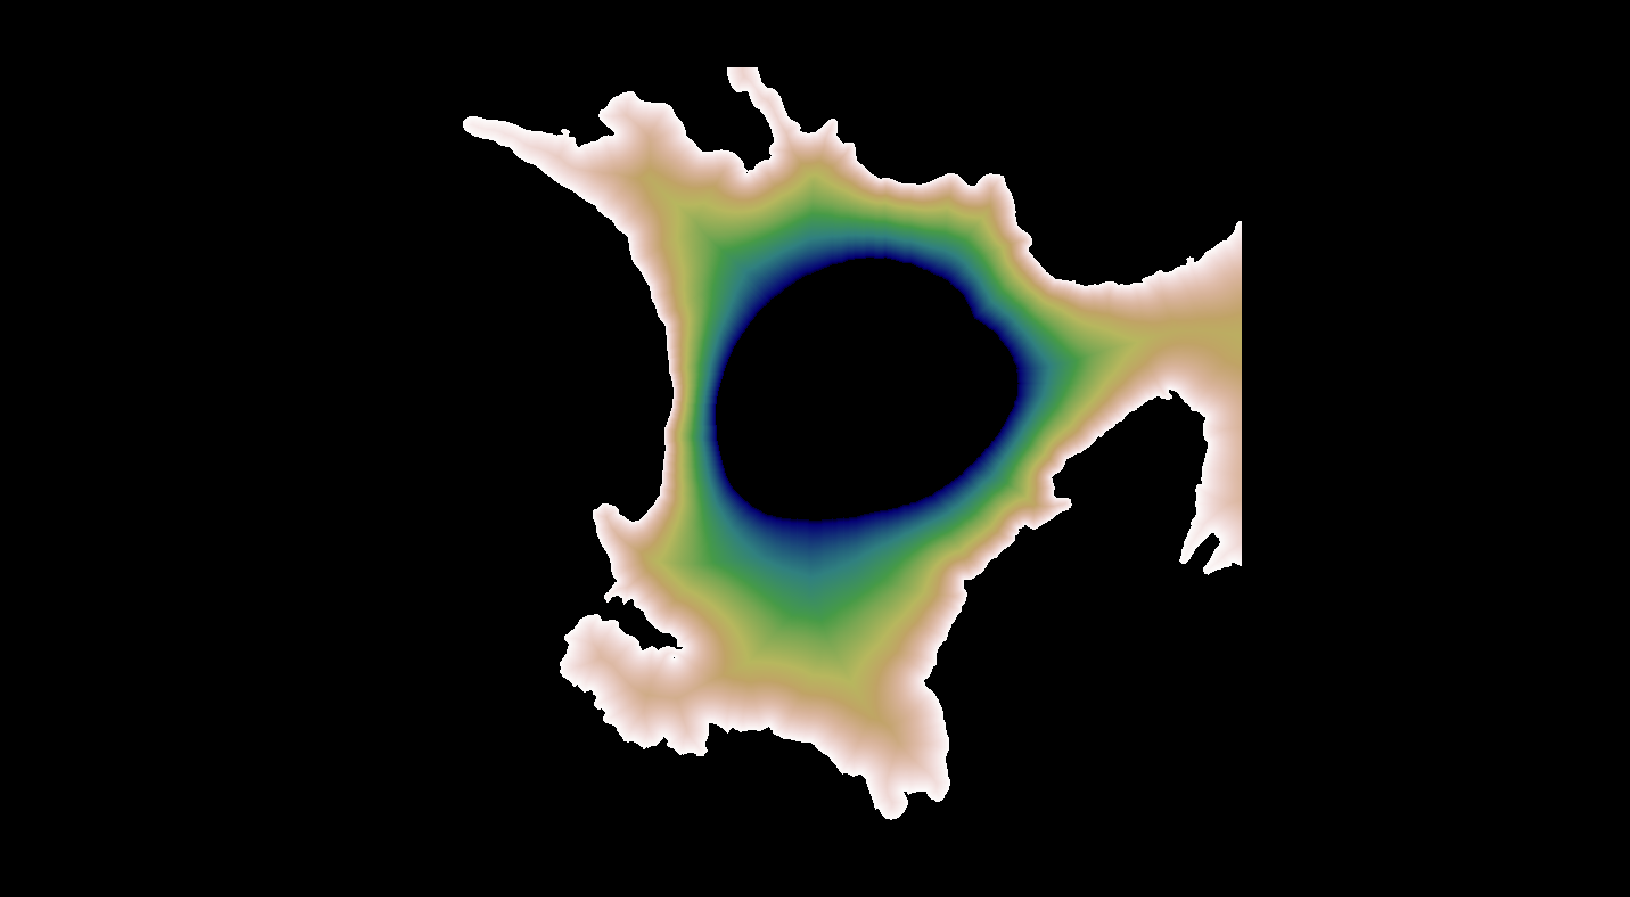

In [88]:
# Normalized distance is an image of the good mask with the pixels outside of the nucleus are given values in a range from 0 (inclusive) to
# 1 (exclusive), based on the pixel's distance from the edge of the nucleus projection

# For the sake of visualization I am giving it values from 0 to 255 in napari

(normalized_distance * 255)
viewer.add_image((normalized_distance * 255),colormap="gist_earth")

nbscreenshot(viewer, canvas_only=True)

### I&J Centers

In [89]:
# i_center and j
ic = int(max(np.unique(i_center)))
jc = int(max(np.unique(j_center)))
ic,jc


(285, 368)

In [90]:
# Creating a box to see if the i,j centers are the coordinates for the center of the nucleus
box_size = 10
redbox_array = []
row_counter = -1
for row in range(cellmask_proj.shape[1]):
    row_counter += 1
    n_row = []
    col_counter = -1
    for col_item in range(cellmask_proj.shape[0]):
        x = 0
        col_counter += 1
        if row_counter >= (ic - box_size/2) and row_counter <= (ic + box_size/2):
            if col_counter >= (jc - box_size/2) and col_counter <= (jc + box_size/2):
                x = 1
        n_row.append(x)
    redbox_array.append(n_row)
redbox_array = np.array(redbox_array,dtype = bool)         
viewer.add_image(redbox_array)

<Image layer 'redbox_array [4]' at 0x2138b0b49d0>

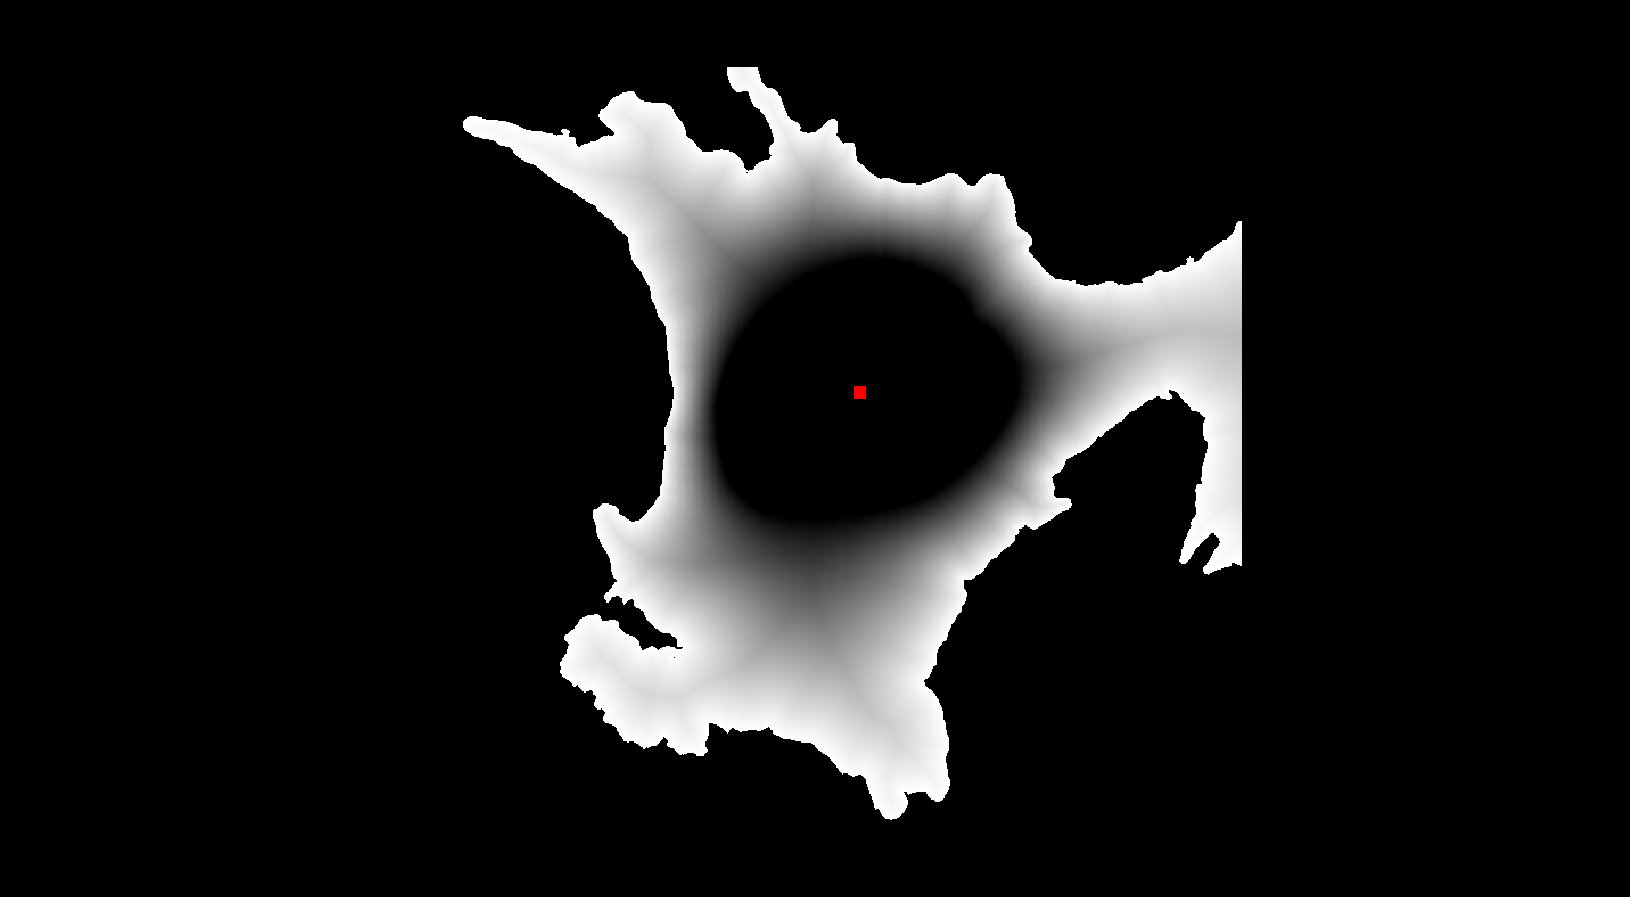

In [91]:
viewer.add_image(normalized_distance)
viewer.add_image(redbox_array,blending="additive",colormap="red")
nbscreenshot(viewer, canvas_only=True)

### Good Mask

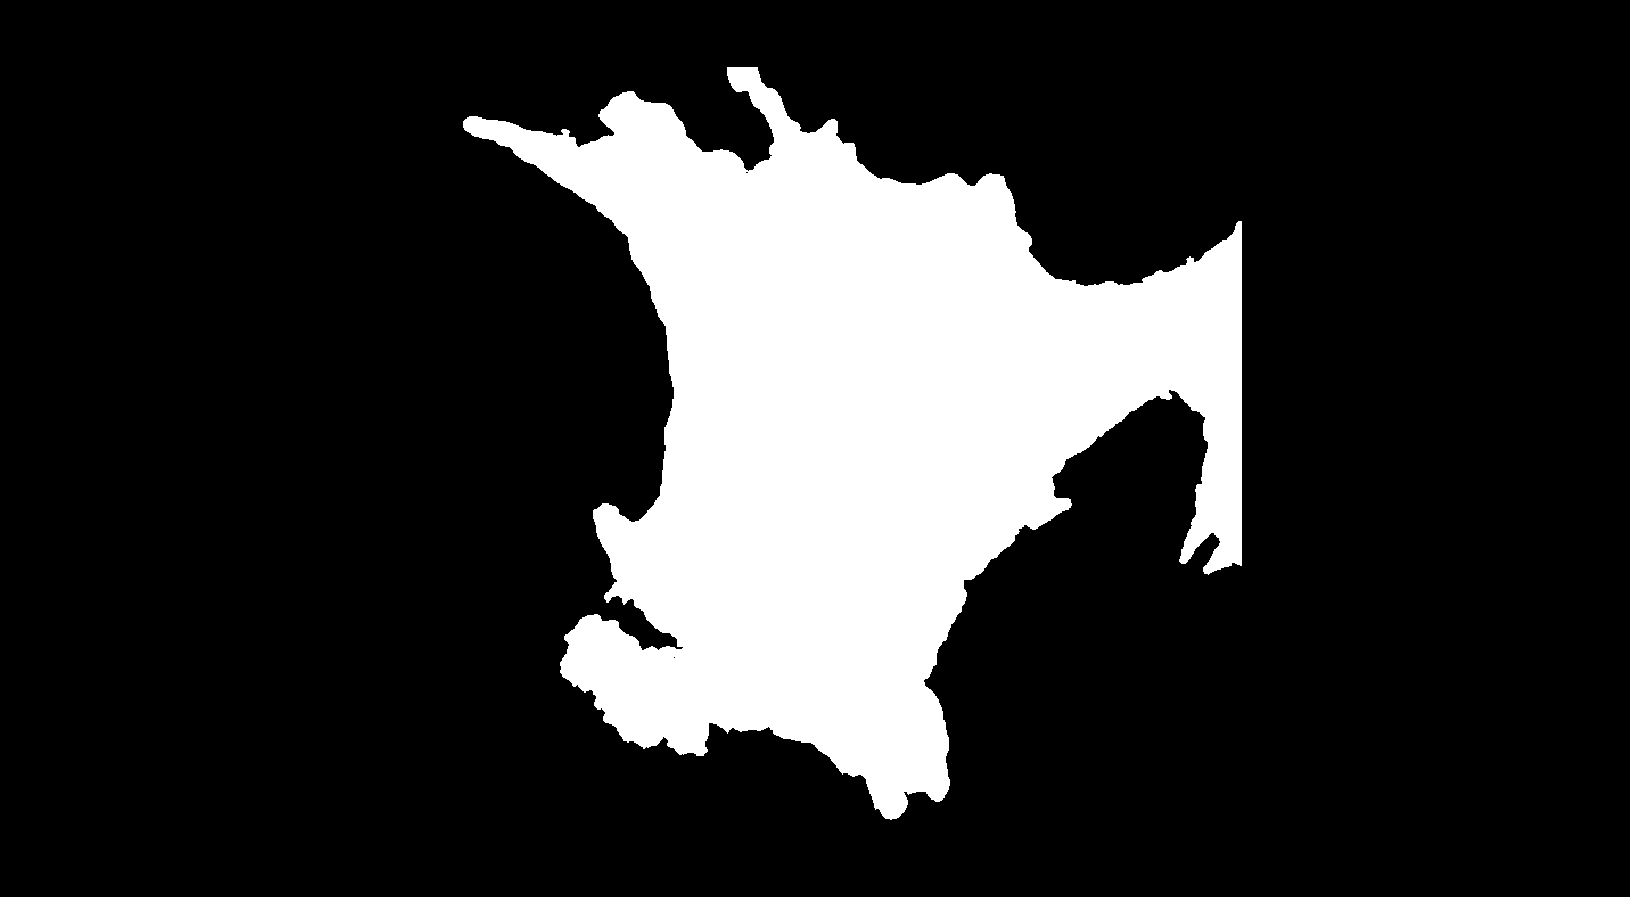

In [92]:
# The good mask will be used to define the bounds of the data that is used in the output(what pixels will be included or omitted).
# In either case it is identical to the labels object.
viewer.add_image(good_mask)
nbscreenshot(viewer, canvas_only=True)

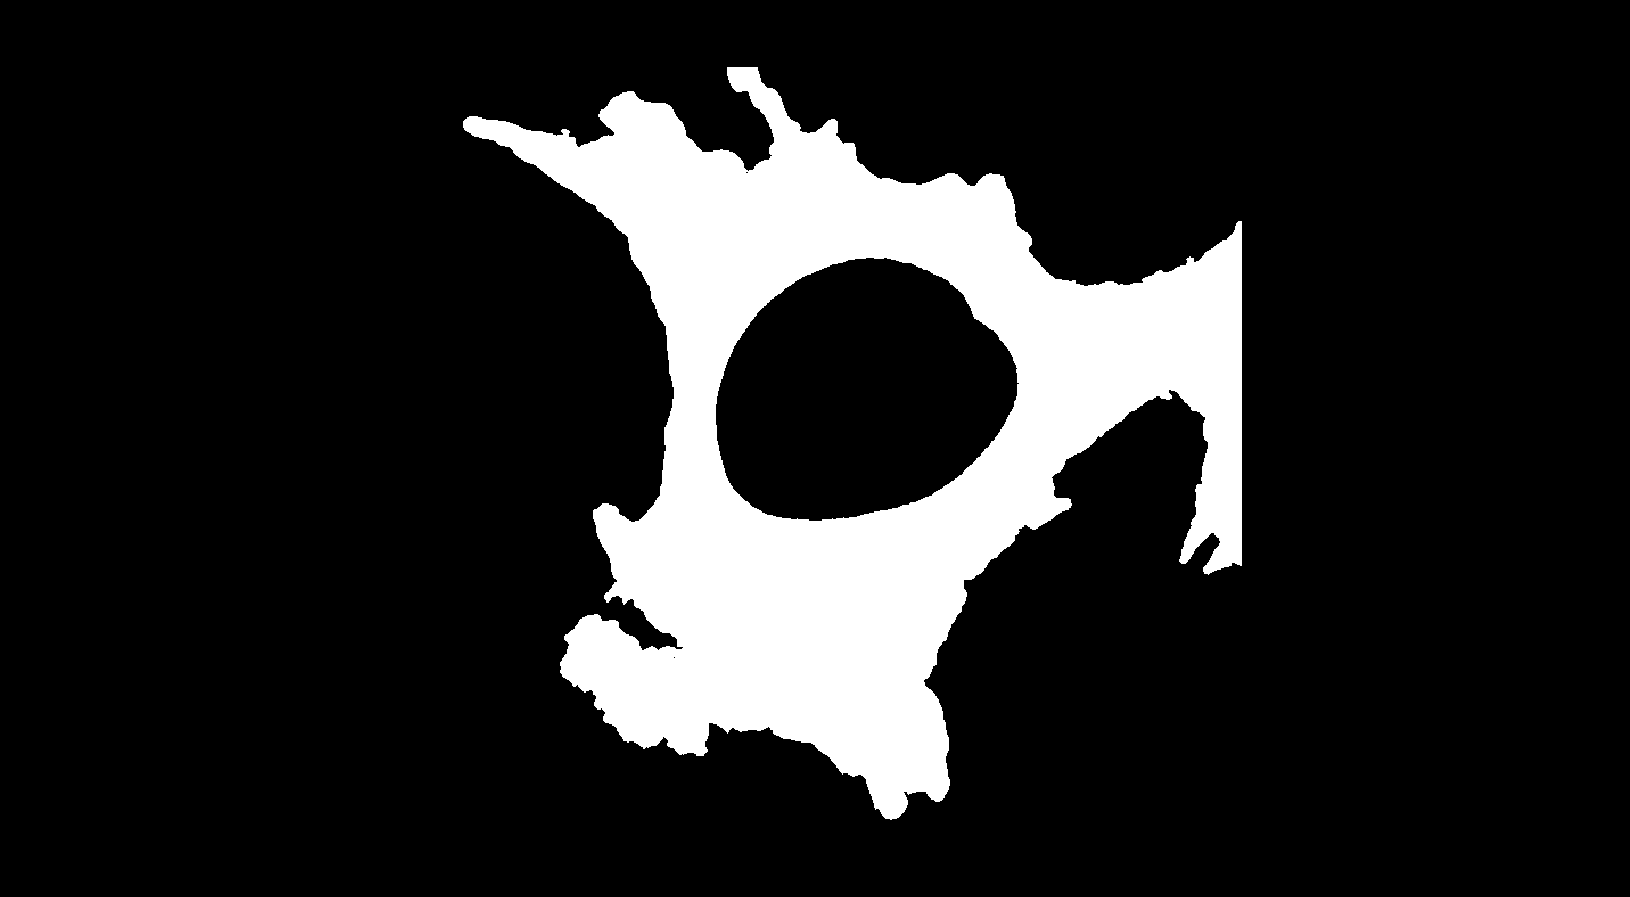

In [94]:
# This is what the good mask would look like if the keep_nuc_bins was false
viewer.add_image(good_mask2)
nbscreenshot(viewer, canvas_only=True)

In [95]:
np.all(labels == good_mask)

True

In [96]:
np.all(labels2 == good_mask2)

True

See? theres a little humor in code

In [97]:
if normalized_distance is None:
        print('WTF!!  normailzed_distance returned wrong')

In [98]:
# ngood_pixels is the amount of pixels in the good_mask covers, the two dimensional pixel area of the cellmask projection.
ngood_pixels = np.sum(good_mask)
ngood_pixels

213249

In [100]:
# This is what the sum of the pixels would be if keep_nuc_bins was false
ngood_pixels2 = np.sum(good_mask2)
ngood_pixels2

166898

In [102]:
# Just as expected, if you subtract the number of pixels from the good_mask by the number of pixels in center_object(nuc)
# you will get the same value
np.sum(good_mask) - np.sum(center_objects)

166898

In [103]:
# good_labels is a (an array of length n (ngood_pixels), that contains the true values of the pixels in labels array indexed by the good_mask).
# basically it only takes in the pixels that were within the good_mask.

# Since these are identical it is an array filled with 1's
good_labels = labels[good_mask]

In [106]:
# same code if keep_nuc_bins was false
good_labels2 = labels2[good_mask2]

In [107]:
np.unique(good_labels),np.unique(good_labels2)

(array([1], dtype=uint16), array([1], dtype=uint16))

In [75]:
### This is my proposed change to the code to prevent the first bin from being combined with the nucleus, while maintaining the same amount of bins
# bin_indexes = (normalized_distance * bin_count).astype(int)

if keep_nuc_bins:
    # To keep the same number of bins the number is decreased by one because the nucleus will also serve as a bin
    # The values will round down, so the pixels very close to the nucleus are rounded down to 0 rather than starting at 1. To avoid this, 1 is added
    # to the entire image
    bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)

    # To undo the effects of 1 being added to the image, everything not in the good mask is set to 0
    bin_indexes[~good_mask] = 0

    # For the nucleus bin
    # Remember that although the values in the nuclear projection are 0, this will count as the first bin because these pixels are within
    # the good mask

    bin_indexes[center_objects] = 0
else:
    # If the nucleus_projection is already excluded, this is much more convenient. The pixels close to the nucleus rounding down to zero is not 
    # an issue because the pixels in the nucleus_projection will not be read anyway.
    bin_indexes = (normalized_distance * (bin_count)).astype(int)

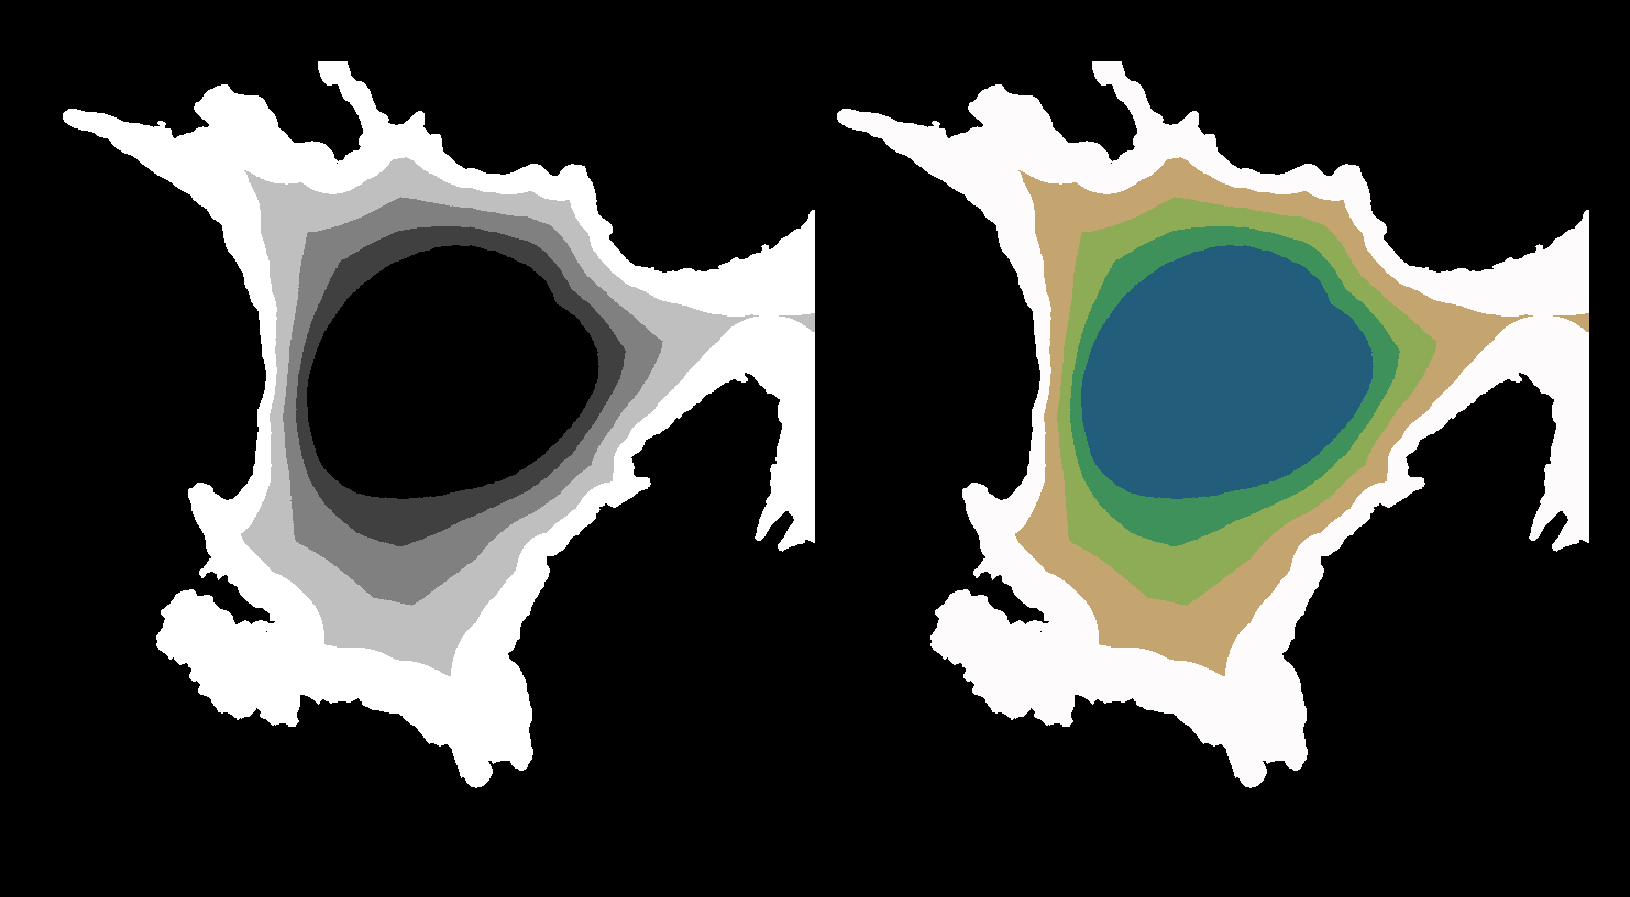

In [126]:
viewer.layers.clear()
viewer.grid.enabled = True
viewer.add_image(bin_indexes + good_mask, colormap="gist_earth")
viewer.add_image(bin_indexes)
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

The image on the left is how the data sees it, but the image on the right shows each bin colored for visualization. Remember that 0's are read in as the first bin.

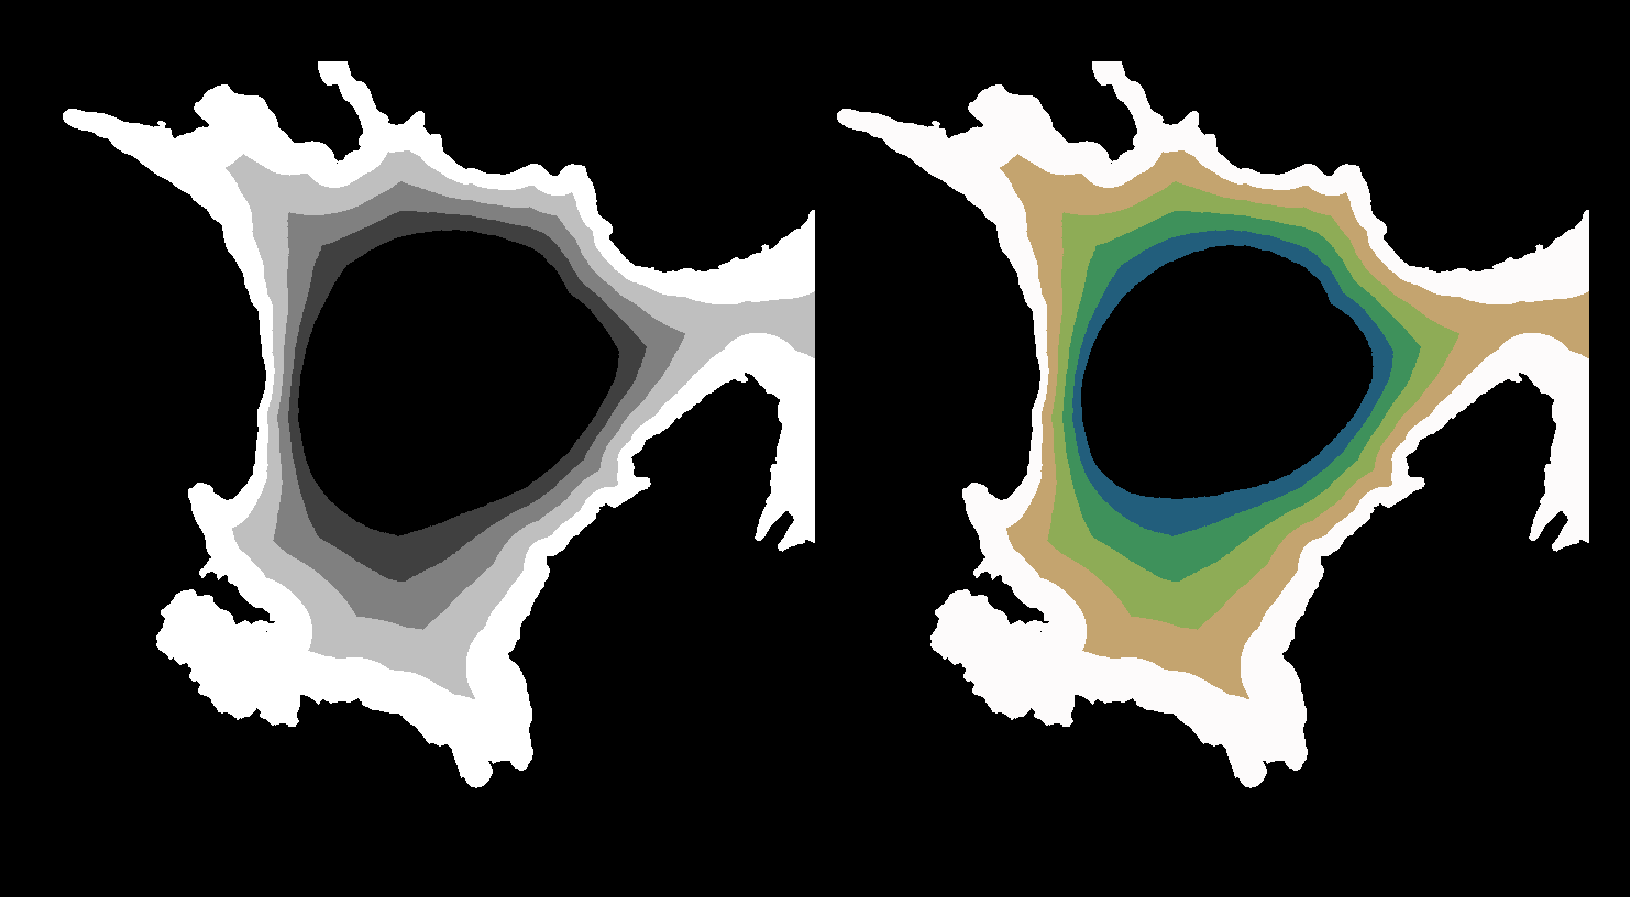

In [127]:
# if keep_nuc_bins was false this is what the bins would look like
viewer.layers.clear()
viewer.grid.enabled = True
bin_indexes2 = (normalized_distance * (bin_count)).astype(int)
bin_indexes2_visual = (normalized_distance * (bin_count) + good_mask2).astype(int)
viewer.add_image(bin_indexes2_visual, colormap="gist_earth")
viewer.add_image(bin_indexes2)
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

Notice how in the first one, the nucleus projection appears bigger, and there only appears to be 4 bins. What is actually happening is that the 0's from the first bin (remember in this example the nucleus projection is excluded), combines with the 0's from the nucleus in a visual sense. This will not affect the data because the code will only read in pixels from the good_mask.

Let's have some fun with the visualization. This is essentially the original img_data image, overlayed with colors representing the bin the individual voxels will be in.

In [173]:
fourdim_bins = []
for bin in range(bin_count):
    bin_image_2d = bin_indexes == bin
    bin_image_2d = apply_mask(bin_image_2d, good_mask)
    bin_image_4d = np.tile(bin_image_2d, (img_data.shape[0],img_data.shape[1],1,1))
    fourdim_bins.append(bin_image_4d)
fourdim_bins = np.array(fourdim_bins)

In [174]:
viewer_bi = napari.Viewer(title = "Bins Image", ndisplay=3)

In [175]:
colors = ["gray","bop orange","yellow","green","blue"]
for bin in range(bin_count):
    viewer_bi.add_image(img_data[5] * fourdim_bins[bin][5],
                        colormap=colors[bin],
                        blending="additive",
                        scale=scale,contrast_limits=([0, 10000]),
                        rotate = (5, 5, 0))


c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully 

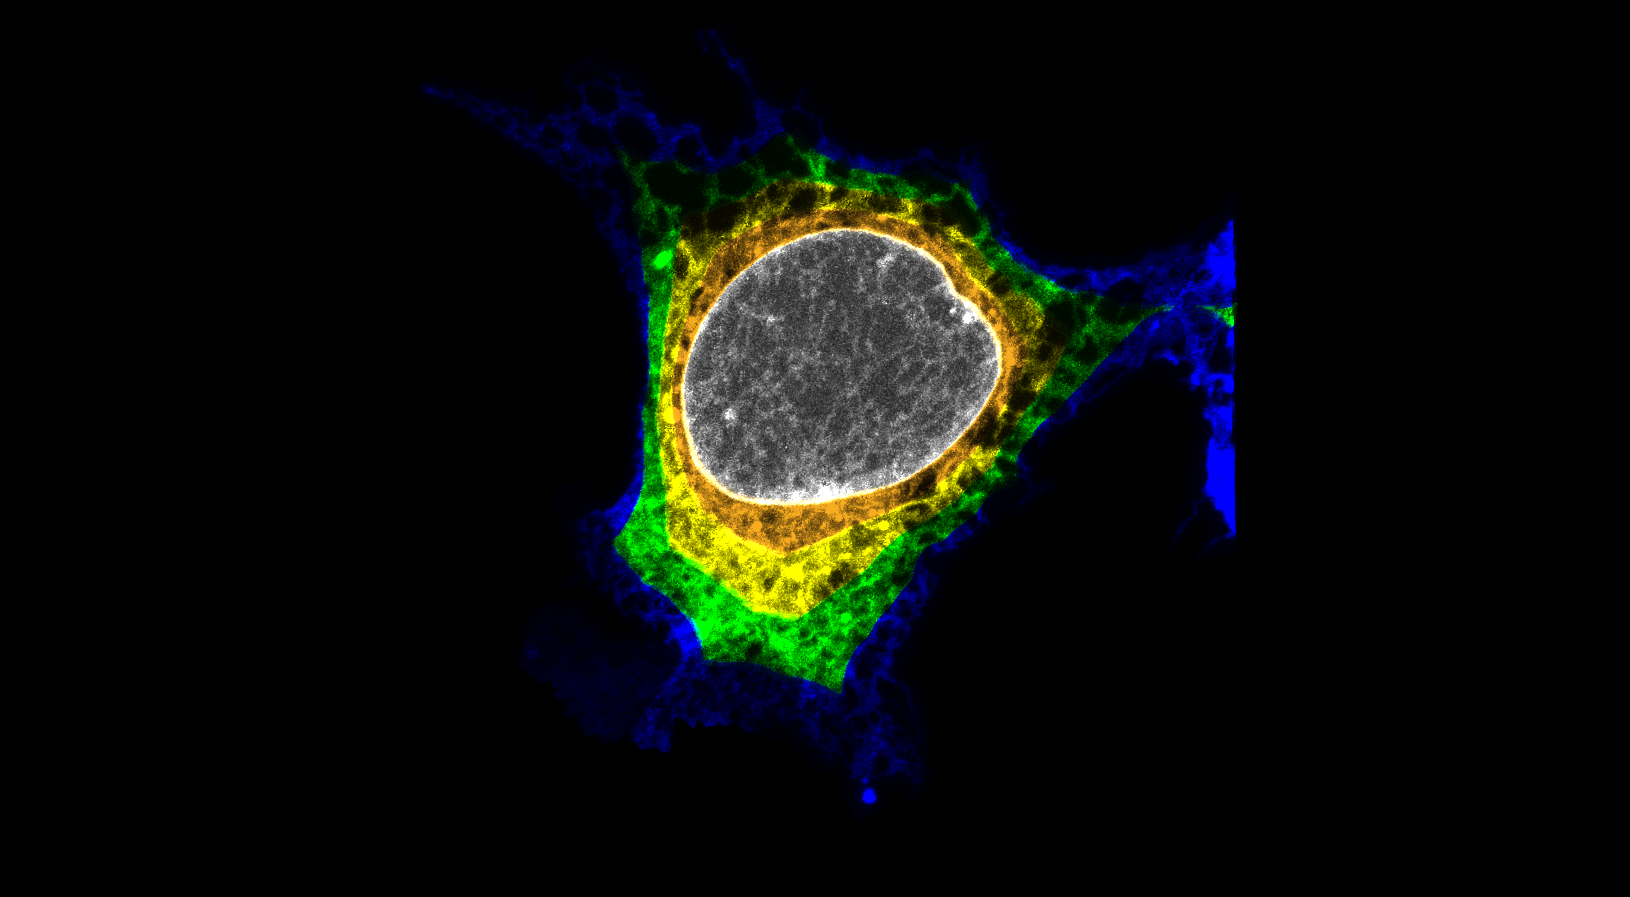

In [177]:
nbscreenshot(viewer_bi, canvas_only=True)

In [180]:
# In either case (keep_nuc_bins TRUE and FALSE) there will be the same number of bins

np.unique(bin_indexes),np.unique(bin_indexes2)

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [181]:
# A safeguard, I belive nothing changes here.
# This basically says, for any instance that a pixel value in bin_indexes number is higher than the number of bins lower it back to,
# the number of bins
bin_indexes[bin_indexes > bin_count] = bin_count

In [182]:
# This code takes in all of the pixels that are in the good_mask and turning them into 0s (item 0)
# Then akes in all the pixels that are in the good_mask and their bin label (item 1)
labels_and_bins = (good_labels - 1, bin_indexes[good_mask])

In [183]:
#If keep_nuc_bins was false this would be
labels_and_bins2 = (good_labels2 - 1, bin_indexes2[good_mask2])

In [186]:
# Creates a matrix (I have know idea) with the dimensions (1 by # of bins), basically creating a array of the sum of the depths (by each (x,y)) 
# in each bin. So technically it is a histogram with the values being the amount of depth (collected by each xy) in each bin... math :|

# Which can be interpreted as the VOXEL volume throughout the bins of the cellmask.

# Thus if the cellmask includes the nucleus, the sum of the array would be the VOXEL volume of the cell

histogram_cmsk = coo_matrix( (cellmask_proj[good_mask], labels_and_bins), shape=(nobjects, bin_count) ).toarray()

In [187]:
#If keep_nuc_bins was false this would be
histogram_cmsk2 = coo_matrix( (cellmask_proj[good_mask2], labels_and_bins2), shape=(nobjects, bin_count) ).toarray()

In [188]:
# That means his code includes the nuclei in bin1
histogram_cmsk

array([[741068, 272625, 368760, 487576, 787464]])

In [189]:
histogram_cmsk2

array([[210248, 272350, 335276, 462693, 635858]])

Checking if the sum is consistent

In [192]:
print(f"The sum of the cell mask histogram was {np.sum(histogram_cmsk)}, and the VOXEL volume of the cell is {np.sum(cellmask_obj)}")
print(f"The sum of the cell mask histogram was {np.sum(histogram_cmsk2)} when keep_nuc_bins is false, and the VOXEL volume of the cell is {np.sum(cellmask_obj)}")

The sum of the cell mask histogram was 2657493, and the VOXEL volume of the cell is 2657493
The sum of the cell mask histogram was 1916425 when keep_nuc_bins is false, and the VOXEL volume of the cell is 2657493


In [204]:
fourdim_bins.shape

(5, 8, 16, 704, 704)

In [210]:
viewer_bi.add_image(cellmask_obj * fourdim_bins[1][0])

<Image layer 'Image' at 0x2138f510ac0>

In [212]:
# Checking if the voxel numbers are consistent checking the VOXEL volumes from the cellmask object.
for i in range(bin_count):
    print(np.sum(cellmask_obj * fourdim_bins[i][0]))

741068
272625
368760
487576
787464


In [214]:
# Using the orgnelle projection this finds the total number of voxels belonging to the organelle in each bin
histogram_org = coo_matrix((org_proj[good_mask],labels_and_bins), shape=(nobjects, bin_count) ).toarray()

In [215]:
histogram_org

array([[28114, 54528, 50271, 51769, 43865]])

In [218]:
# For some reason there were objects that were in the nuclear bin that were not masked out, I think there is something up with the infer code
# That is why I had to mask it by the cyto mask
# But the code in the function looks correct
### This was fixed and they are now equal
np.sum(histogram_org),np.sum(apply_mask(organelle_masks[test_org],cellmask_obj))

(228547, 228547)

In [219]:
# This creates an array with the summed intensities of the image (in the organelle channel) in each bin
histogram_img = coo_matrix((img_proj[good_mask],labels_and_bins), shape=(nobjects, bin_count) ).toarray()

In [220]:
histogram_img

array([[893695342, 627978146, 618743354, 617301949, 642351710]],
      dtype=uint32)

In [221]:
np.sum(histogram_img), np.sum(apply_mask(original_intensities[test_org], cellmask_obj))

(3400070501, 3400070501)

In [222]:
# This was also changed
# bin_indexes = (normalized_distance * bin_count).astype(int)
if keep_nuc_bins:
        # For the exterior bins
        bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)
        bin_indexes[~good_mask] = 0
        # For the nucleus bin
        bin_indexes[center_objects] = 0
else:
    bin_indexes = (normalized_distance * (bin_count)).astype(int)

In [223]:
sum_by_object_cmsk = np.sum(histogram_cmsk,1)

In [224]:
# This is the same sum I checked earlier, The total cellmask volume (in voxels)
sum_by_object_cmsk

array([2657493])

In [225]:
sum_by_object_org = np.sum(histogram_org, 1)

In [226]:
# The total volume (in voxels) of the organelle objects
sum_by_object_org

array([228547])

In [228]:
# The total intensity within the cellmask in the organelle 3D image (in the specified organelle's channel)
sum_by_object_img = np.sum(histogram_img, 1)

In [229]:
sum_by_object_img

array([3400070501], dtype=uint32)

In [232]:
# Creates an array with values that (in two dimensional space), list many pixels each bin was composed of (area in pixels)

number_at_distance = coo_matrix(( np.ones(ngood_pixels), labels_and_bins), (nobjects, bin_count)).toarray()

In [240]:
#if keep_nuc_bins was false this is what number_at_distance would be
number_at_distance2 = coo_matrix(( np.ones(ngood_pixels2), labels_and_bins2), (nobjects, bin_count)).toarray()

In [233]:
number_at_distance

array([[46351., 17238., 24578., 36911., 88171.]])

In [241]:
number_at_distance2

array([[13266., 17706., 23466., 36812., 75648.]])

In [243]:
# confirming that it is the sum of the pixels in the good mask
np.sum(number_at_distance),np.sum(good_mask)

(213249.0, 213249)

In [244]:
np.sum(number_at_distance2),np.sum(good_mask2)

(166898.0, 166898)

In [246]:
# This code just futher confirms it
sum_by_object = np.sum(number_at_distance, 1)
sum_by_object

array([213249.])

In [247]:
# Quite litterally just stacks the good_mask pixel sum in the array by the number of bins, this will be used later to make a ratio
sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count))[0]

In [248]:
sum_by_object_per_bin

array([[213249., 213249., 213249., 213249., 213249.]])

In [250]:
# For each bin the percentage of the good_mask area at each bin takes up, This is not the perecentage of the cellmask volume because,
# The depth of the cell is not always constant in the Z axis
fraction_at_bin = number_at_distance / sum_by_object_per_bin 

In [251]:
fraction_at_bin

array([[0.21735624, 0.08083508, 0.11525494, 0.17308874, 0.41346501]])

In [252]:
# i is a veritcal gradient and j is a horizontal gradient
i, j = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]

In [253]:
viewer = napari.Viewer()

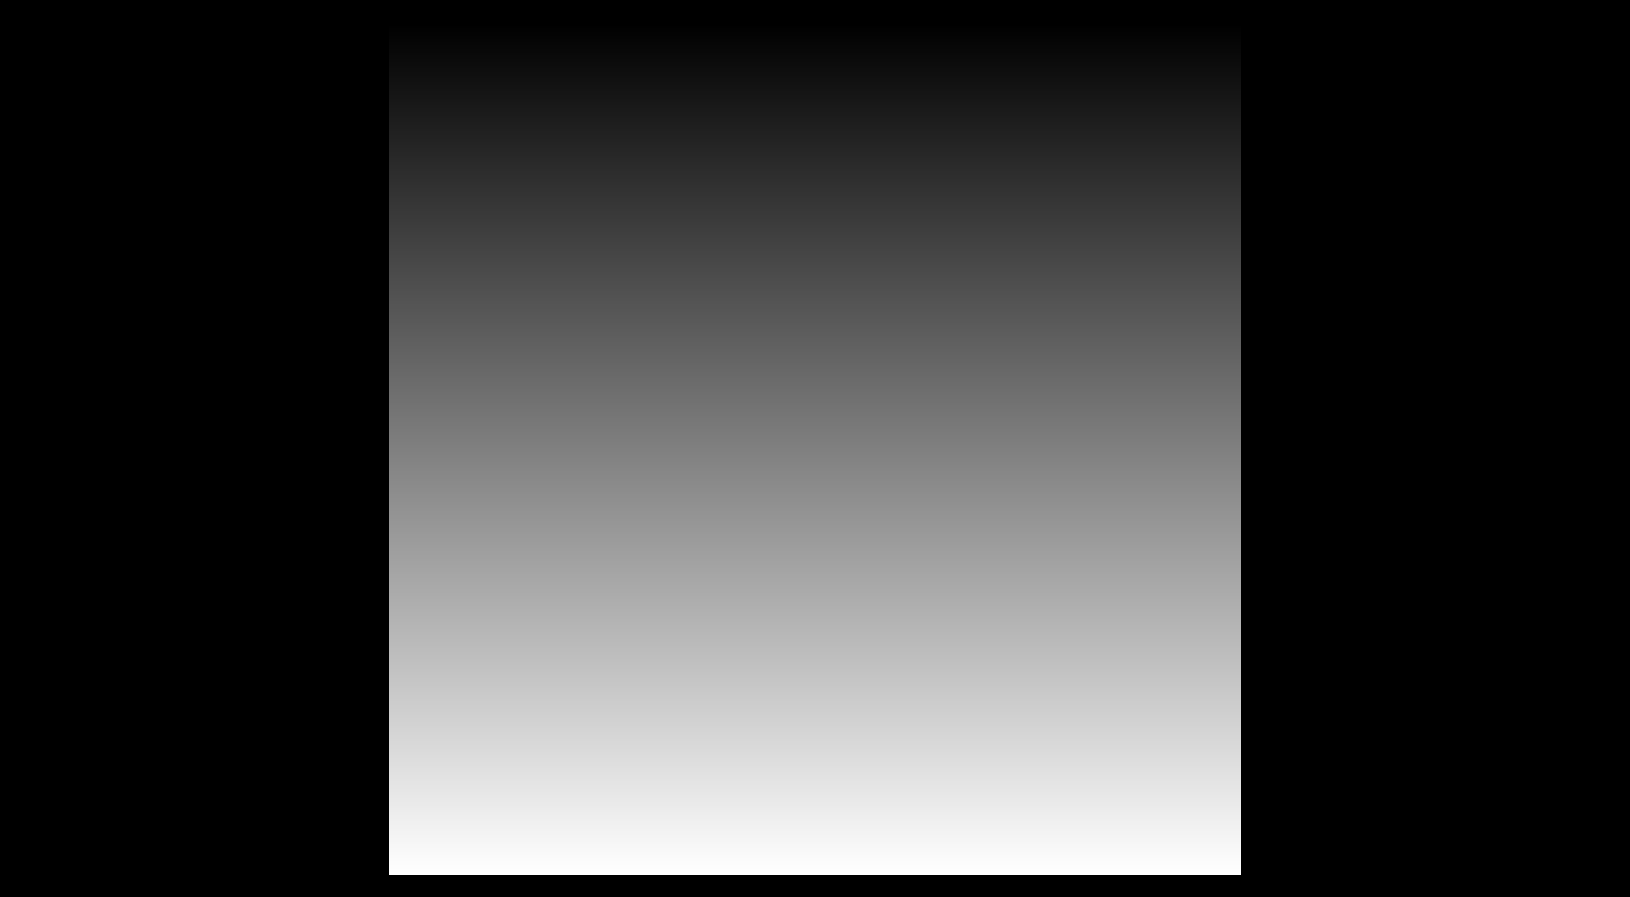

In [254]:
viewer.add_image(i)
nbscreenshot(viewer, canvas_only=True)

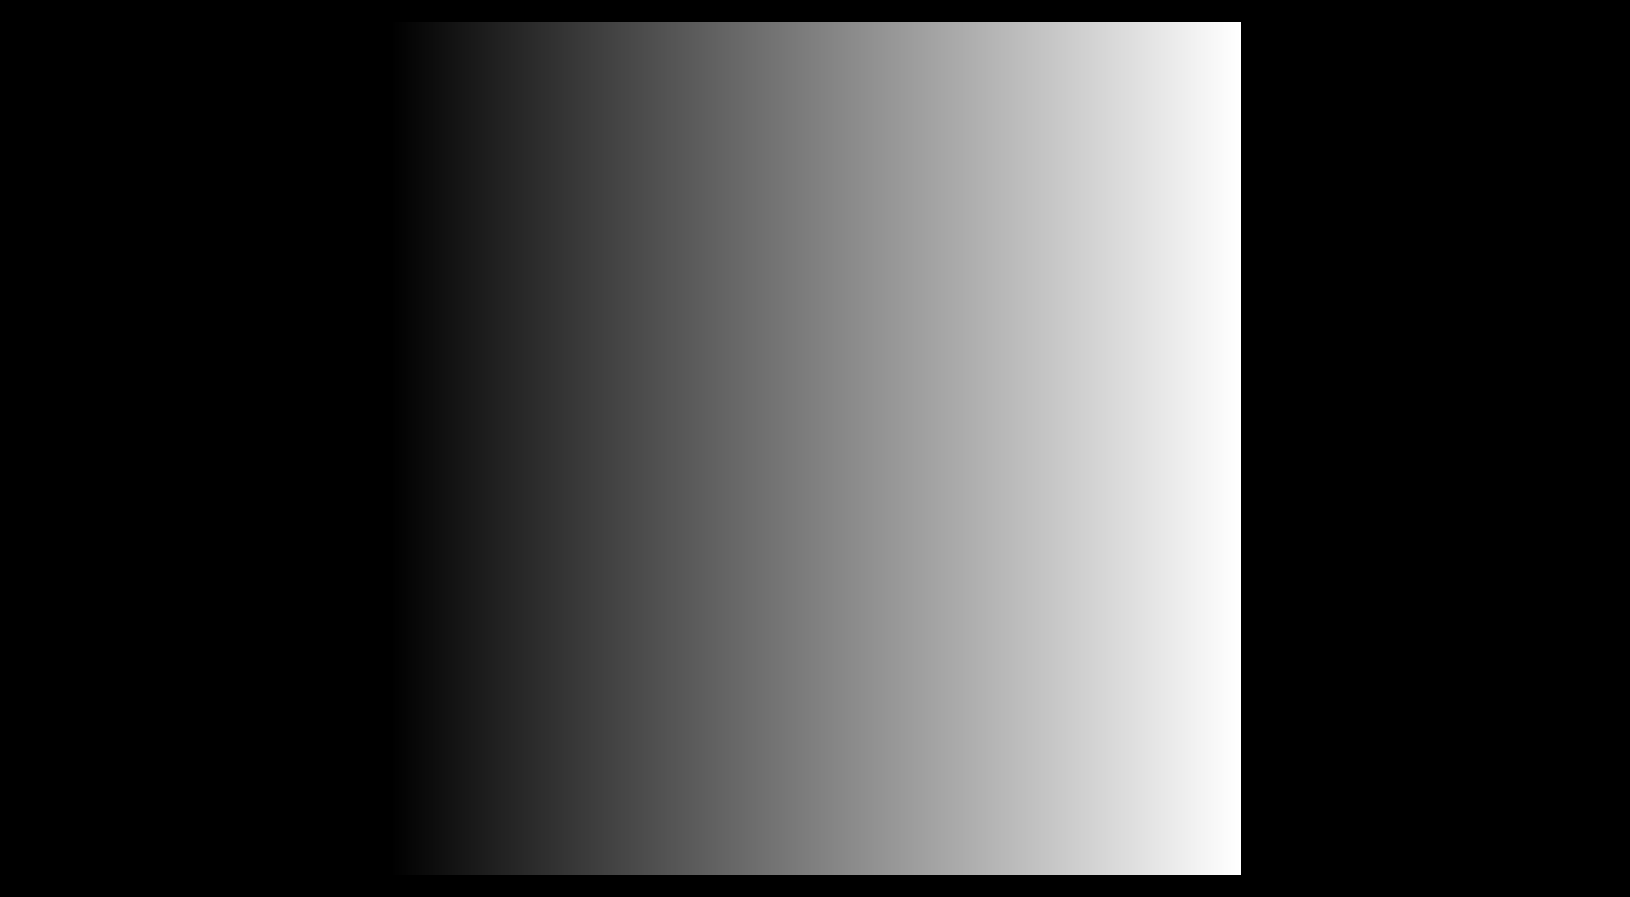

In [255]:
viewer.add_image(j)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
# imask is a boolean array, which has an item for each pixel in the good mask (because it was indexed by it)
# The value depends of if at that pixel in the good mask, was the row number in the i gradient larger than the i_center number (i_center)
# is any array filled with the same number, which is the x coordinate of the center of the nucleus.
imask = i[good_mask] > i_center[good_mask]

In [ ]:
# Same thing but for the columns
jmask = j[good_mask] > j_center[good_mask]

In [ ]:
# The absolute distance of the i masks compared to the absolute distance of the j masks
absmask = abs(i[good_mask] - i_center[good_mask]) > abs(
        j[good_mask] - j_center[good_mask]
    )

In [ ]:
# splits the good_mask into 8 equal bins
radial_index = (
        imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4
    )

In [ ]:
radial_index

In [ ]:
# code to see what radial_index looks like
radial_index_test = []
counter = -1
for row in range(len(good_mask)):
    new_row = []
    for col in range(len(good_mask[0])):
        if good_mask[row][col] == True:
            counter += 1
            new_row.append(radial_index[counter])
        else:
            new_row.append(0)
    radial_index_test.append(new_row)
radial_index_test = np.array(radial_index_test)


In [ ]:
radial_index_test[good_mask] + 0

In [ ]:
viewer.add_image(radial_index_test)
viewer.add_labels(radial_index_test)
nbscreenshot(viewer, canvas_only=True)

So here is how the CV is calculated. So in each wedge you get the mean and then from those means you can determine the standard deviation. The coefficient of variation is that standard deviation over the mean of wedges.

In [ ]:
# establishing empty bins
statistics = []
stat_names =[]
cv_cmsk = []
cv_obj = []
cv_img = []

Lets do this for the nucleus bin

# FOR LOOP

In [ ]:
# retrieves the bin_mask by doing a logical and
bin_mask = good_mask & (bin_indexes == bin)

In [ ]:
viewer.add_image(bin_mask)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
# The number of pixels in the bin
bin_pixels = np.sum(bin_mask)
print(bin_pixels)

In [ ]:
# an array of trues with the same total as the cell before
bin_labels = labels[bin_mask]

In [ ]:
bin_labels, sum(bin_labels)

In [ ]:
# The radial index but in the shape of the bin
bin_radial_index = radial_index[bin_indexes[good_mask] == bin]

In [ ]:
np.unique(bin_radial_index)

In [ ]:
# code to see what bin_radial_index looks like
bin_radial_index_test = []
counter = -1
for row in range(len(bin_mask)):
    new_row = []
    for col in range(len(bin_mask[0])):
        if bin_mask[row][col] == True:
            counter += 1
            new_row.append(bin_radial_index[counter])
        else:
            new_row.append(0)
    bin_radial_index_test.append(new_row)
bin_radial_index_test = np.array(bin_radial_index_test)

In [ ]:
viewer.add_image(bin_radial_index_test)
viewer.add_labels(bin_radial_index_test)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
# Similar code to last time, takes the arrays of 1s and makes them 0s and the second item is an array with the pixels and the label
# corresponding to the wedge it is in
labels_and_radii = (bin_labels - 1, bin_radial_index)

In [ ]:
labels_and_radii

In [ ]:
# How many pixels are in each wedge
pixel_count = coo_matrix( (np.ones(bin_pixels), labels_and_radii), (nobjects, 8) ).toarray()
print(pixel_count)

In [ ]:
# Checking if the sum is consistent
np.sum(pixel_count),bin_pixels

In [ ]:
# For each wedge in the bin the amount of voxels within the cellmask
radial_counts_cmsk = coo_matrix( (cellmask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
print(radial_counts_cmsk)

In [ ]:
# checking if the sum is consistent
np.sum(radial_counts_cmsk), histogram_cmsk[0,bin]

In [ ]:
# In each wedge how many voxels were there that were part of the organelle (volume of the organelle)
radial_counts = coo_matrix( (org_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
print(radial_counts)

In [ ]:
# checking if the sum us consistent
np.sum(radial_counts), histogram_org[0,bin]

In [ ]:
# In each wedge the sum of the intensities in each bin
radial_values = coo_matrix( (img_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
print(radial_values)

In [ ]:
# Ditto
np.sum(radial_values),histogram_img[0,bin]

In [ ]:
# I guess its checking if any of the wedges equal 0
mask = pixel_count == 0

In [ ]:
mask

In [ ]:
# Essentially this is doing a calculation to see how much z you are getting per xy in each wedge
radial_means_cmsk = np.ma.masked_array(radial_counts_cmsk / pixel_count, mask)

In [ ]:
print(radial_counts_cmsk / pixel_count)

In [ ]:
radial_means_cmsk

In [ ]:
# the coefficient of variation calculation, this shows much z varies across the wedge
radial_cv_cmsk = np.std(radial_means_cmsk, 1) / np.mean(radial_means_cmsk, 1)
print(radial_cv_cmsk)

In [ ]:
# I guess its setting the empty values to 0
radial_cv_cmsk[np.sum(~mask, 1) == 0] = 0

In [ ]:
# No changes here
radial_cv_cmsk

In [ ]:
radial_cv_cmsk.mask = np.sum(~mask, 1) == 0

In [ ]:
# No changes, its probably a safeguard
radial_cv_cmsk

In [ ]:
# The amount of organelle voxels in each wedge divided by the pixel count of each wedge
radial_means_obj = np.ma.masked_array(radial_counts / pixel_count, mask)

In [ ]:
radial_means_obj

In [ ]:
# It does the CV calculation with the voxels in each bin divided by the pixel count of each bins
radial_cv_obj = np.std(radial_means_obj, 1) / np.mean(radial_means_obj, 1)
radial_cv_obj[np.sum(~mask, 1) == 0] = 0
radial_cv_obj.mask = np.sum(~mask, 1) == 0

In [ ]:
# I guess it varies a lot in the first bin
radial_cv_obj

In [ ]:
# In this line, the amount of intensity in each wedges is divided by the pixel count. I guess in each calculation the cv provides a number
# that shows the variability within each bin itself
radial_means_img = np.ma.masked_array(radial_values / pixel_count, mask)
print(radial_means_img)


In [ ]:
# same code but for the intensities
radial_cv_img = np.std(radial_means_img, 1) / np.mean(radial_means_img, 1)
radial_cv_img[np.sum(~mask, 1) == 0] = 0
radial_cv_img.mask = np.sum(~mask, 1) == 0
radial_cv_img

In [ ]:
# I'm going to change this to make the name of it nuc_bin
# bin_name = str(bin) if bin > 0 else "Ctr"
if keep_nuc_bins == True:
    bin_name = str(bin) if bin > 0 else "nuc_bin"
else:
    bin_name = str(bin)

In [ ]:
print(bin_name)

In [ ]:
# After each bin is done with the calculations the results will be appended here
stat_names.append(bin_name)
cv_cmsk.append(float(np.mean(radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
cv_obj.append(float(np.mean(radial_cv_obj)))
# cv_img.append(float(np.mean(radial_cv_obj))) # This was an error
cv_img.append(float(np.mean(radial_cv_img)))

In [ ]:
# This is where the column names come from, and the data is from the functions from earlier

stats_dict={'organelle': org_name,
                'mask': 'cell',
                'radial_n_bins': bin_count,
                'radial_bins': [stat_names],
                'radial_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
                'radial_org_vox_cnt': [histogram_org.squeeze().tolist()],
                'radial_org_intensity': [histogram_img.squeeze().tolist()],
                'radial_n_pix': [number_at_distance.squeeze().tolist()],
                'radial_cm_cv':[cv_cmsk],
                'radial_org_cv':[cv_obj],
                'radial_img_cv':[cv_img],
}

In [ ]:
# converts it to a table
stats_tab = pd.DataFrame(stats_dict)
(stats_tab)

Then the stats tab table and the bin_indexes are returned

Now to breakdown get_zernike_stats

# INPUTS

In [ ]:
#Remember that the default value of to bool is True, thus it had to be turned off for the image projection.

# The cellmask projection is the cellmask object 3d array summed on the z
cellmask_proj =  create_masked_Z_projection(cellmask_obj)

# The cellmask projection is the organelle objects 3d array summed on the z
org_proj = create_masked_Z_projection(org_obj,cellmask_obj)

# The orignal czi image (with the specific organelle), with the intensity values summed on the z
img_proj = create_masked_Z_projection(org_img,cellmask_obj,to_bool=False)

# The name of the organelle
organelle_name = organelle_name

# The nucleus projection
nucleus_proj = create_masked_Z_projection(nuclei_obj,cellmask_obj)
        
# zernike_degree: int = 9
# This is fine, im just using the variable but it is the same
zernike_degree = n_zernike


In [ ]:
# Uses a boolean version of the cellmask projection and then labels them, so the output is 0,1 and not bool

labels = label(cellmask_proj>0) #extent as 0,1 rather than bool

In [ ]:
np.unique(labels)

In [ ]:
viewer = np.Viewer()

In [ ]:
viewer.add_image(labels)
viewer.add_labels(labels)
nbscreenshot(viewer, canvas_only=True)

In [ ]:
# The get_zernike_indexes function creates a two dimensional array with the zernike indexes up to the limit
# Notice the pattern, from 0 to the zernike degree the indexes consist of the number modulo 2 and go up in steps of two from then on 
# Until it reaches the number itself
zernike_indexes = centrosome.zernike.get_zernike_indexes(zernike_degree + 1)

In [ ]:
zernike_indexes

In [ ]:
# Uses the labels and the indexes to get the zernike polynomials
z = zernike_polynomial(labels, zernike_indexes)

In [ ]:
print(z)

In [ ]:
z.dtype

In [ ]:
np.unique(z)

In [ ]:
# Each calculation returns the magnitude and phase
z_cm = zernicke_stat(cellmask_proj, z)
z_org = zernicke_stat(org_proj, z)
z_nuc = zernicke_stat(nucleus_proj, z)
z_img = zernicke_stat(img_proj, z)

In [ ]:
z_cm[0]

In [ ]:
z_cm[1]

In [ ]:
# There was an error in the naming of one of the columns

# These are where the column names come from
# nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
stats_tab = pd.DataFrame({'organelle':organelle_name,
                                'mask':'cell',
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_cm_mag':[z_cm[0].tolist()],
                                'zernike_cm_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_nuc_mag':[z_nuc[0].tolist()],
                                'zernike_nuc_phs':[z_nuc[1].tolist()],
                                'zernike_img_mag':[z_img[0].tolist()],
                                # 'zernike_img_mag':[z_img[1].tolist()]
                                'zernike_img_phs':[z_img[1].tolist()]}
                                )

NOW FOR THE DEPTH STATS FUNCTION

# INPUTS

In [2]:
# I changed the order just to stop it from printing
# These are similar inputs to the ones before

cellmask_obj,
organelle_mask,
organelle_name,
nuclei_obj,
organelle_obj = organelle_masks[test_org]
organelle_img = original_intensities[test_org]

NameError: name 'cellmask_obj' is not defined

In [27]:
# These are not the same projections from before, they are summed on the and x,y axis instead of the z
# The org and img masks were changed to cellmask
cellmask_proj = create_masked_depth_projection(cellmask_obj)
org_proj = create_masked_depth_projection(organelle_obj,cellmask_obj.astype(bool))
img_proj = create_masked_depth_projection(organelle_img,cellmask_obj.astype(bool), to_bool=False)
nucleus_proj = create_masked_depth_projection(nuclei_obj,cellmask_obj.astype(bool)) if nuclei_obj is not None else None

In [22]:
# Creates z bins which have the same number of items as the number of z's where the cell exists
z_bins = [i for i in range(cellmask_obj.shape[0])]

In [26]:
img_proj

array([ 41345488,  66639392, 104925243, 120227946, 159395854, 198195971,
       218348144, 231671867, 251365368, 263090404, 265829662, 262043721,
       235811752, 207809780, 184108176, 101485225], dtype=uint32)

In [23]:
z_bins

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [24]:
# This is where the column names come from
stats_tab = pd.DataFrame({'organelle':organelle_name,
                            'mask':'cell',
                            'n_z':cellmask_obj.shape[0],
                            'z':[z_bins],
                            'z_cm_vox_cnt':[cellmask_proj.tolist()],
                            'z_org_vox_cnt':[org_proj.tolist()],
                            'z_org_intensity':[img_proj.tolist()],
                            'z_nuc_vox_cnt':[nucleus_proj.tolist()]})

In [25]:
stats_tab

organelle  mask  n_z                                                  z   
0        ER  cell   16  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  \

                                        z_cm_vox_cnt   
0  [118658, 151337, 153810, 154926, 161384, 16768...  \

                                       z_org_vox_cnt   
0  [14, 214, 1897, 5886, 11536, 16552, 20802, 223...  \

                                     z_org_intensity   
0  [41345488, 66639392, 104925243, 120227946, 159...  \

                                       z_nuc_vox_cnt  
0  [0, 0, 15248, 35260, 39905, 43239, 44968, 4583...